In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import assets.helper as b3


## dre_pivot

In [5]:
import time


In [3]:
# variables 0
url = 'https://sistemaswebb3-listados.b3.com.br/listedCompaniesPage/?language=pt-br' 
search_url = 'https://sistemaswebb3-listados.b3.com.br/listedCompaniesPage/search?language=pt-br' 
start = 1
batch = 120
bins = 20
bin_size = 50
chunksize = 10**6  # Adjust this value based on your available memory

# variables 1
app_folder = 'datasets/'
cols_b3_companies = ['pregao', 'company_name', 'cvm', 'listagem', 'ticker', 'tickers', 'asin', 'cnpj', 'site', 'setor', 'subsetor', 'segmento', 'atividade', 'escriturador', 'url']
cols_b3_tickers = ['ticker', 'company_name']
cols_world_markets = ['symbol', 'shortName', 'longName', 'exchange', 'market', 'quoteType']
cols_yahoo = {'symbol': 'str', 'shortName': 'str', 'longName': 'str', 'exchange': 'category', 'market': 'category', 'quoteType': 'category', 'ticker': 'str', 'exchange_y': 'category', 'tick_y': 'str', 'tick': 'str'}
cols_info = ['symbol', 'shortName', 'longName', 'longBusinessSummary', 'exchange', 'quoteType', 'market', 'sector', 'industry', 'website', 'logo_url', 'country', 'state', 'city', 'address1', 'phone', 'returnOnEquity', 'beta3Year', 'beta', 'recommendationKey', 'recommendationMean']
# cols_cotahist = ['TICKER', 'tick', 'Symbol', 'Symbol Type', 'Exchange', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Dividends', 'Stock Splits']
# cols_cotahist = ['Date', 'open', 'high', 'low', 'close', 'volume', 'adjusted close', 'dividend amount', 'split coefficient']
cols_tickers = ['company', 'symbol', ]
cols_cotahist = cols_tickers + ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits']
company_info_cols = ['market', 'sector', 'industry', 'country', 'state', 'city', 'zip', 'quoteType', 'exchange', 'financialCurrency', 'symbol', 'shortName', 'longName', 'longBusinessSummary', 'currency', 'recommendationKey', 'recommendationMean', 'fullTimeEmployees', 'website', 'logo_url', 'address1', 'address2', 'phone']
cols_nsd = ['company', 'dri', 'dri2', 'dre', 'data', 'versao', 'auditor', 'auditor_rt', 'cancelamento', 'protocolo', 'envio', 'url', 'nsd']
cols_dre = ['Companhia', 'Trimestre', 'Demonstrativo', 'Conta', 'Descrição', 'Valor','Url']
cols_dre_math = ['Companhia', 'Trimestre', 'Demonstrativo', 'Conta', 'Descrição', 'Valor', 'Url', 'nsd']
cols_all =  cols_b3_companies + company_info_cols + cols_cotahist + cols_dre

# Remove specific elements from the list using list comprehension
to_move = ['Companhia', 'Trimestre', 'Date', 'ticker']
cols_all = [col for col in cols_all if col not in to_move]
cols_all = to_move + cols_all

demo = ['Demonstrações Financeiras Padronizadas', 'Informações Trimestrais']
cmbGrupo = ['Dados da Empresa']
cmbQuadro = ['Demonstração do Resultado', 'Balanço Patrimonial Ativo', 'Balanço Patrimonial Passivo', 'Demonstração do Fluxo de Caixa', 'Demonstração de Valor Adicionado', 'Demonstração do Resultado Abrangente']

last_quarters = ['3', '4']
all_quarters = ['6', '7']


# dre new columns
fsdemo = 'FS_Demonstrativo'
fsdesc = 'FS_Descrição'
fscol = 'FS_Conta'
fsval = 'FS_Valor'

columns = ['Companhia', 'Trimestre', 'Demonstrativo', 'Conta', 'Descrição', 'Valor', 'Url', 'nsd', 'demosheet']
columns = ['Companhia', 'Trimestre', 'Demonstrativo', 'Conta', 'Descrição', 'Valor', 'Url', 'nsd']



In [7]:
def read_or_create_dataframe(file_name, cols):
    """
    Read a pandas DataFrame from a compressed file, or create an empty DataFrame if the file doesn't exist.

    Args:
    file_name (str): the name of the file (without the extension) to read/create.
    cols (list): a list of column names for the DataFrame.

    Returns:
    pd.DataFrame: the DataFrame read from the file, or an empty DataFrame if the file doesn't exist.
    """
    # Construct the full path to the file using the varsys data_path.
    file_path = os.path.join(b3.data_path, f'{file_name}.zip')
    try:
      df = download_from_gcs(file_name)
      pass
    except Exception as e:
      try:
        df = pd.read_pickle(file_path)  # Try to read the file as a pickle.
        # df = upload_to_gcs(df, file_name)
      except Exception as e:
        # print(f'Error occurred while reading file {file_name}: {e}')
        df = pd.DataFrame(columns=cols)
        
    df.drop_duplicates(inplace=True)  # Remove any duplicate rows (if any).
    
    print(f'{file_name}: total {len(df)} items')
    return df[cols]

def clean_dre_math(dre):
  try:
    # clean
    dre.loc[:, 'Companhia'] = dre['Companhia'].str.replace(' EM RECUPERACAO JUDICIAL', '')
    dre.loc[:, 'Companhia'] = dre['Companhia'].str.replace(' EM LIQUIDACAO EXTRAJUDICIAL', '')
    dre.loc[:, 'Companhia'] = dre['Companhia'].str.replace(' EM LIQUIDACAO', '')

    # standartization
    dre['Companhia'] = dre['Companhia'].astype('category')
    dre['Demonstrativo'] = dre['Demonstrativo'].astype('category')
    dre['Trimestre'] = pd.to_datetime(dre['Trimestre'], yearfirst=True, dayfirst=True, infer_datetime_format=True)
    dre['Conta'] = dre['Conta'].astype('str')
    dre['Conta'] = dre['Conta'].astype('category')
    dre['Descrição'] = dre['Descrição'].astype('category')
    dre['Valor'] = pd.to_numeric(dre['Valor'], errors='coerce')
    dre['Url'] = dre['Url'].astype('category')
    dre['nsd'] = pd.to_numeric(dre['Url'].str.replace('https://www.rad.cvm.gov.br/ENET/frmGerenciaPaginaFRE.aspx?NumeroSequencialDocumento=','', regex=False).str.replace('&CodigoTipoInstituicao=1','', regex=False), errors='ignore')
    dre['nsd'] = dre['nsd'].astype('str')
    dre['nsd'] = dre['nsd'].astype('category')

    dre.reset_index(drop=True, inplace=True)
    dre = (dre.sort_values(by=['Companhia', 'Trimestre', 'Conta'],
                        key=lambda col: pd.to_datetime(col, format='%d/%m/%Y') if col.name == 'Trimestre' else col))

    dre = dre[b3.cols_dre_math]
  except Exception as e:
    pass
  return dre

def remaining_time(start_time, size, i):
  counter = i + 1
  remaining_items = size - counter
  percentage = (counter)/(size)

  # elapsed time
  running_time = (time.time() - start_time)
  avg_time_per_item = running_time / (i + 1)
  # remaining time
  remaining_time = remaining_items * avg_time_per_item
  hours, remainder = divmod(int(float(remaining_time)), 3600)
  minutes, seconds = divmod(remainder, 60)
  remaining_time_formatted = f'{int(hours)}h {int(minutes):02}m {int(seconds):02}s'

  progress = f'{counter}, {remaining_items}, {percentage:.2%}%, {avg_time_per_item:.6f}s, {remaining_time_formatted}'

  return progress

def save_and_pickle(df, df_name):
  df.to_pickle(b3.data_path + f'{df_name}.zip')
  df = upload_to_gcs(df, df_name)

  return df



### Code

In [174]:
import assets.dre_pivot as var_dre_pivot

In [86]:
file_name = 'dre_intel'
dre_intel = read_or_create_dataframe(file_name, cols_dre_math)
dre_intel = clean_dre_math(dre_intel)


dre_intel: total 1635172 items


In [87]:

dre_intel['CDD'] = dre_intel['Conta'].astype('str') + ' - ' + dre_intel['Descrição'].astype('str') + ' - ' + dre_intel['Demonstrativo'].astype('str')
groups = dre_intel.groupby(by='Companhia', group_keys=False)


In [ ]:
pd.DataFrame(dre_intel['CDD'].unique()).to_csv('columns.csv')

In [ ]:
file_name = 'dre_pivot'
# dre_pivot = read_or_create_dataframe(file_name, cols_dre_math)
dre_pivot = pd.DataFrame(columns=var_dre_pivot.columns)

In [166]:
file_name = 'dre_pivot'
file_path = os.path.join(b3.data_path, f'{file_name}.zip')
dre_pivot = pd.read_pickle(file_path)  # Try to read the file as a pickle.


In [221]:
cias = dre_pivot['Companhia'].unique().tolist()
cias

['2W ECOBANK SA',
 '2W ENERGIA SA',
 '3A COMPANHIA SECURITIZADORA',
 '3R PETROLEUM OLEO E GAS SA',
 '521 PARTICIPACOES SA ',
 '524 PARTICIPACOES SA',
 'ACO VERDE DO BRASIL SA',
 'ACRUX SECURITIZADORA SA',
 'ADVANCED DIGITAL HEALTH MEDICINA PREVENTIVA SA',
 'AEGEA SANEAMENTO E PARTICIPACOES SA',
 'AERIS IND E COM DE EQUIP PARA GER DE ENG SA',
 'AES BRASIL ENERGIA SA',
 'AES BRASIL OPERACOES SA',
 'AES ELPA SA',
 'AES TIETE ENERGIA SA',
 'AES TIETE SA',
 'AETATIS SECURITIZADORA SA',
 'AFLUENTE GT DE ENERGIA ELETRICA SA',
 'AFLUENTE TRANSMISSAO DE ENERGIA ELETRICA SA',
 'AGRENCO LIMITED',
 'AGROGALAXY PARTICIPACOES SA',
 'AGUAS DE TERESINA SANEAMENTO SPE SA',
 'AGUAS DO RIO 1 SPE SA',
 'AGUAS DO RIO 4 SPE SA',
 'AGUAS GUARIROBA SA',
 'AGV HOLDING SA',
 'ALFA HOLDINGS SA',
 'ALGAR TELECOM SA',
 'ALIANSCE SHOPPING CENTERS SA',
 'ALIANSCE SONAE SHOPPING CENTERS SA',
 'ALIUM PARTICIPACOES SA',
 'ALLIED TECNOLOGIA SA',
 'ALLIS PARTICIPACOES SA',
 'ALLPARK EMPREENDIMENTOS PARTICIPACOES E SERVIC

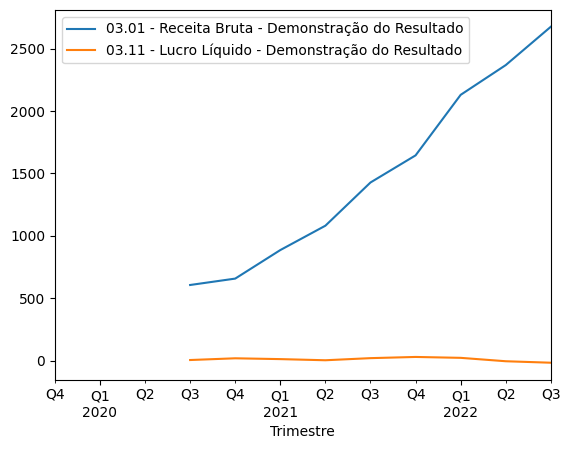

In [238]:
cia = 'AGROGALAXY PARTICIPACOES SA'
mask = dre_pivot['Companhia'] == cia
dre_pivot[mask].set_index('Trimestre')[['03.01 - Receita Bruta - Demonstração do Resultado', '03.11 - Lucro Líquido - Demonstração do Resultado']].rolling(4).mean().plot();

In [106]:
avpi = []
start_time = time.time()
size = len(groups)


In [ ]:
for item, group in enumerate(groups):
    progress = remaining_time(start_time, size, item)
    avpi.append(progress.split(',')[3])

    company = group[0]
    df = group[1]
    df.reset_index(drop=True, inplace=True)

    pivot = pd.pivot_table(data=df, index=['Trimestre'], columns=['CDD'], values=['Valor'], aggfunc='max', fill_value=0)

    pivot = pivot.reset_index(col_level=1)
    pivot.columns = ['Trimestre', *['{}{}'.format(col, '') for _, col in pivot.columns[1:]]]
    pivot.insert(0, 'Companhia', company)

    dre_pivot = pd.concat([dre_pivot, pivot], ignore_index=True).fillna(0)
    print(f'{progress} {company} {df.shape}')
    pd.DataFrame(avpi).to_csv(app_folder + file_name + '.csv', index=False)


In [155]:
company = group[0]
df = group[1]
df.reset_index(drop=True, inplace=True)


In [160]:
pivot = pd.pivot_table(data=df, index=['Trimestre'], columns=['CDD'], values=['Valor'], aggfunc='max', fill_value=0.0)
pivot = pivot.reset_index(col_level=1)
pivot.columns = ['Trimestre', *['{}{}'.format(col, '') for _, col in pivot.columns[1:]]]
pivot.insert(0, 'Companhia', company)

pivot

Companhia  Trimestre  00.01 - Ações Ordinárias - Composição do Capital  \
0  2W ECOBANK SA 2019-12-31                                         113548407   
1  2W ECOBANK SA 2020-03-31                                         113548407   
2  2W ECOBANK SA 2020-06-30                                         113548407   

   00.01.01 - Ações Ordinárias em Tesouraria - Composição do Capital  \
0                                                  0                   
1                                                  0                   
2                                                  0                   

   00.01.02 - Ações Ordinárias Outras - Composição do Capital  \
0                                                  0            
1                                                  0            
2                                                  0            

   00.02 - Ações Preferenciais - Composição do Capital  \
0                                                  0     
1                                                  0     
2                                                  0     

   00.02.01 - Ações Prerenciais em Tesouraria - Composição do Capital  \
0                                                  0                    
1                                                  0                    
2                                                  0                    

   00.02.02 - Ações Prerenciais Outras - Composição do Capital  \
0                                                  0             
1                                                  0             
2                                                  0             

   01 - Ativo Total - Balanço Patrimonial Ativo  \
0                                       424.330   
1                                       398.729   
2                                       412.000   

   01.01 - Ativo Circulante de Curto Prazo - Balanço Patrimonial Ativo  ...  \
0                                            286.849                    ...   
1                                            263.080                    ...   
2                                            258.639                    ...   

   18.09 - Remuneração de Capital de Terceiros por Valor Agregado - Análise do Valor Agregado  \
0                                           0.196897                                            
1                                           0.071811                                            
2                                          25.960319                                            

   18.09.01 - Juros Pagos a Terceiros por Valor Agregado - Análise do Valor Agregado  \
0                                           0.091531                                   
1                                          25.662397                                   
2                                          -8.934828                                   

   18.09.02 - Aluguéis Pagos a Terceiros por Valor Agregado - Análise do Valor Agregado  \
0                                                  0                                      
1                                                  0                                      
2                                                  0                                      

   18.10 - Remuneração de Capital Próprio por Valor Agregado - Análise do Valor Agregado  \
0                                                  0                                       
1                                                  0                                       
2                                                  0                                       

   18.10.01 - Juros Sobre Capital Próprio por Valor Agregado - Análise do Valor Agregado  \
0                                                  0                                       
1                                                  0                                       
2                                                  0               

In [153]:
pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Columns: 214 entries, Trimestre to 18.11.03 - Taxa de Proventos Gerados (Remuneração de Capital Próprio por Receita Bruta - Análise do Valor Agregado_Valor
dtypes: datetime64[ns](1), float64(102), int64(111)
memory usage: 5.1 KB


In [ ]:

# save
dre_pivot = save_and_pickle(dre_pivot, file_name)
print('saved')


## Test

In [17]:
file_path = 'datasets/nsd_links.zip'

In [18]:
nsd = pd.read_pickle(file_path)  # Try to read the file as a pickle.


In [20]:
nsd.columns

Index(['company', 'dri', 'dri2', 'dre', 'data', 'versao', 'auditor',
       'auditor_rt', 'protocolo', 'envio', 'url', 'nsd'],
      dtype='object')

In [ ]:
b3_companies.fillna('', inplace=True)


In [ ]:
b3_companies.reset_index(drop=True, inplace=True)


In [ ]:
b3_companies.drop_duplicates(inplace=True)


In [ ]:
b3_companies

## cotahist

In [70]:
cotahist = pd.read_pickle('datasets/cotahist.zip')

In [73]:
company = 'EZTEC'

In [84]:
corp = cotahist.groupby('company')

In [95]:
companies = ['AREZZO CO', 'B3', 'CARREFOUR BR', 'YDUQS PART']

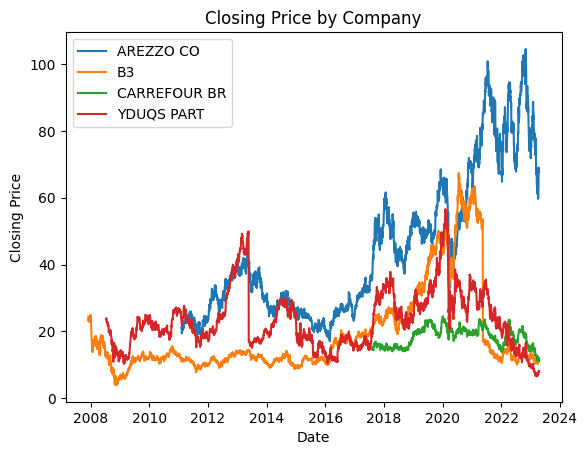

In [96]:
for company in companies:
    data = corp.get_group(company)
    plt.plot(data['Date'], data['Close'], label=company)

# add labels to the plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price by Company')
plt.legend()

# show the plot
plt.show()


In [81]:
cotahist.columns

Index(['company', 'symbol', 'Date', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'Dividends', 'Stock Splits'],
      dtype='object')

d:\Fausto Stangler\Documentos\Python\DSH\.venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


company
3R PETROLEUM    Axes(0.125,0.2;0.775x0.68)
3TENTOS         Axes(0.125,0.2;0.775x0.68)
ACO ALTONA      Axes(0.125,0.2;0.775x0.68)
ALFA CONSORC    Axes(0.125,0.2;0.775x0.68)
ALFA FINANC     Axes(0.125,0.2;0.775x0.68)
                           ...            
WIZ CO          Axes(0.125,0.2;0.775x0.68)
WLM IND COM     Axes(0.125,0.2;0.775x0.68)
XP INC          Axes(0.125,0.2;0.775x0.68)
YDUQS PART      Axes(0.125,0.2;0.775x0.68)
ZAMP SA         Axes(0.125,0.2;0.775x0.68)
Length: 346, dtype: object

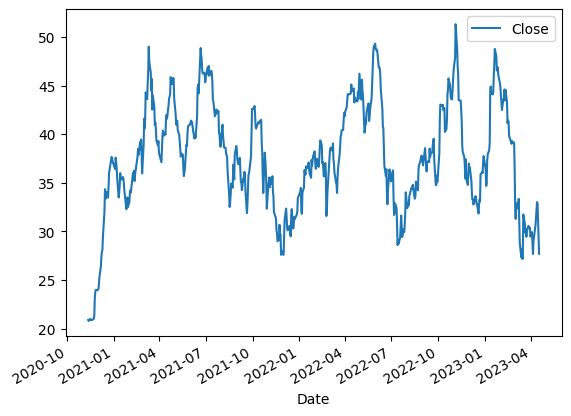

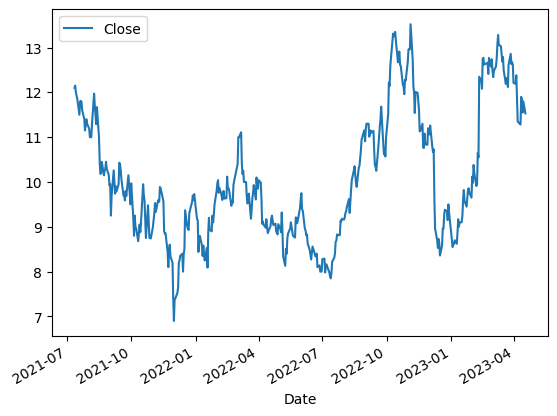

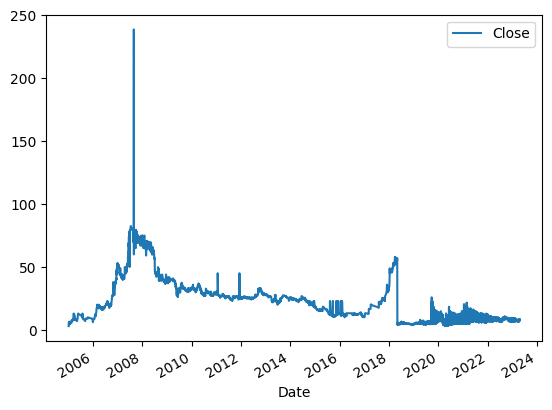

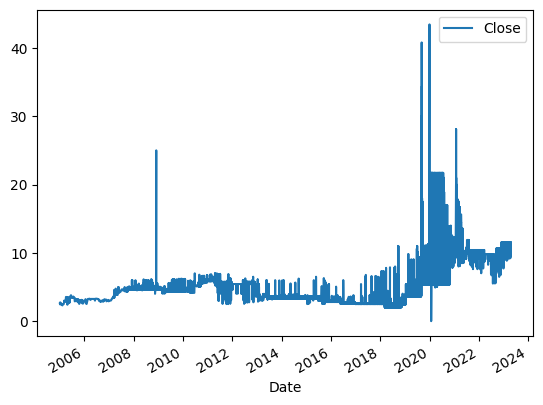

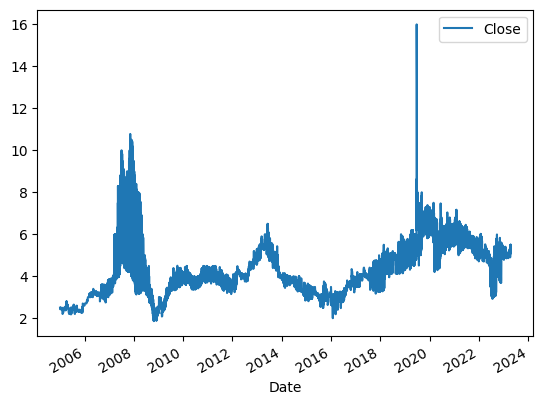

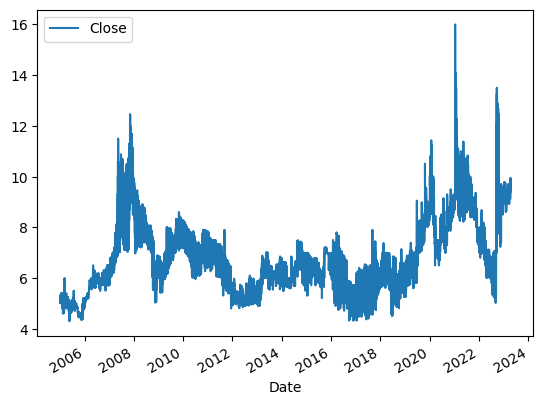

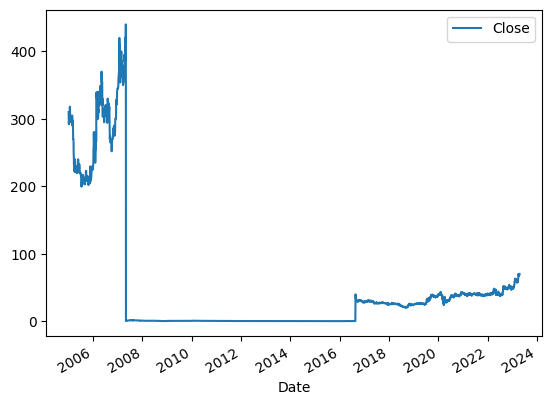

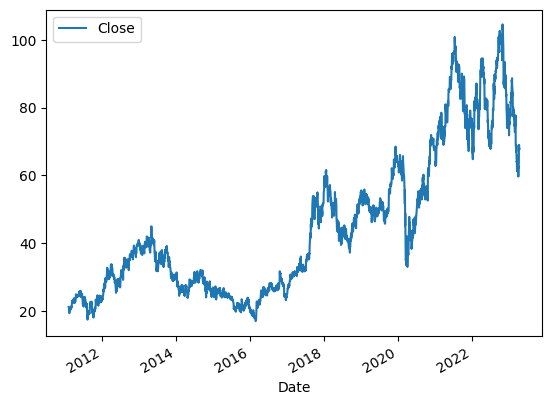

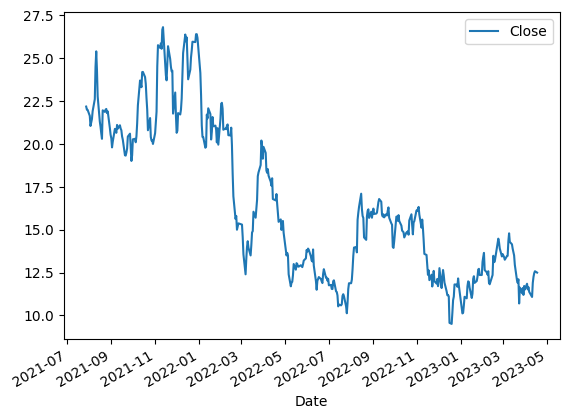

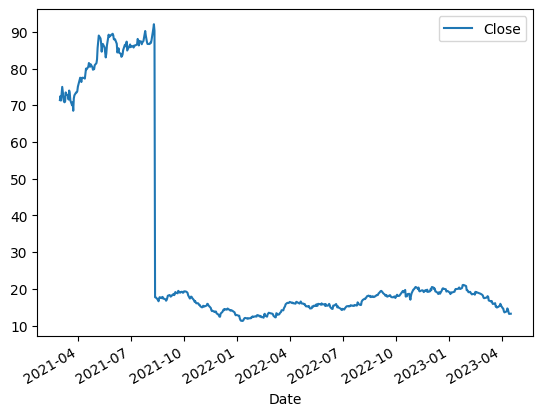

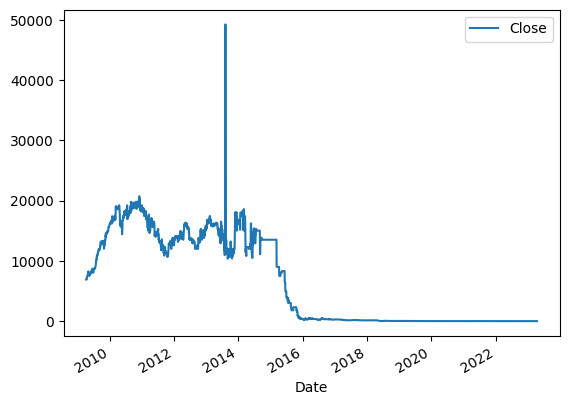

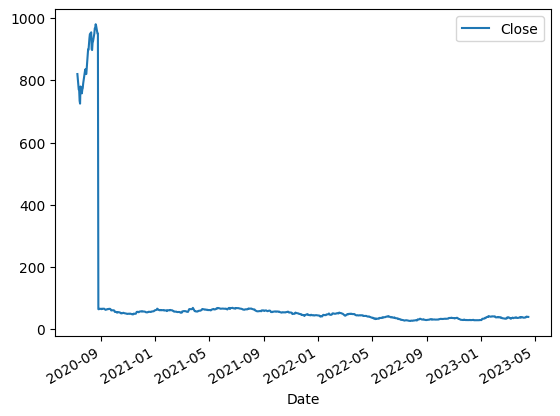

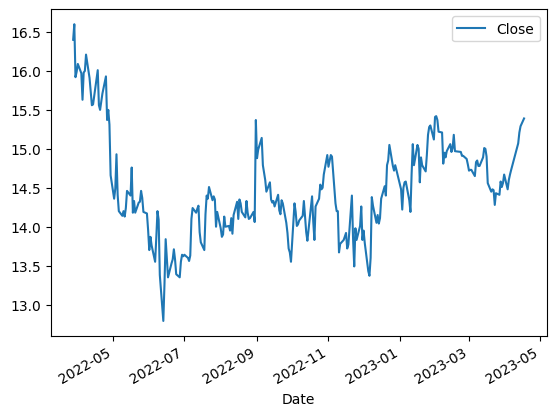

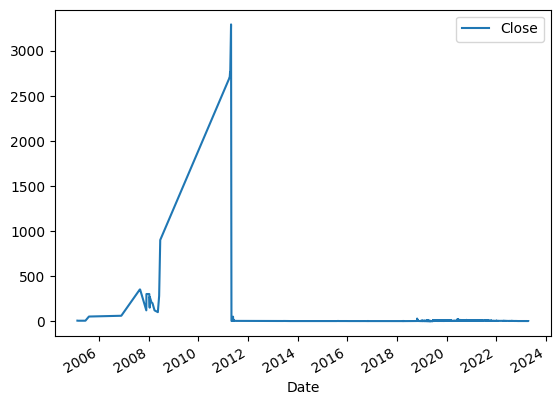

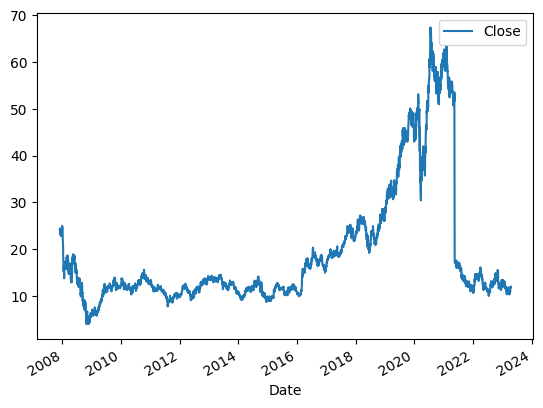

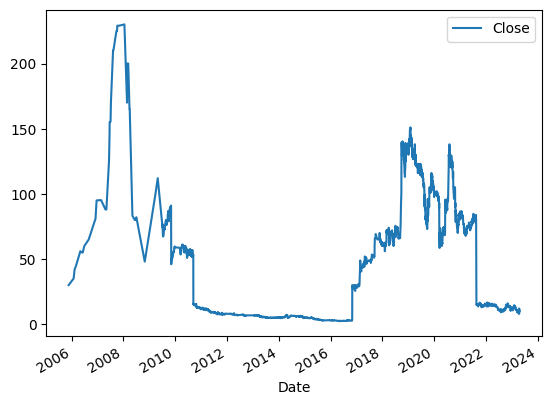

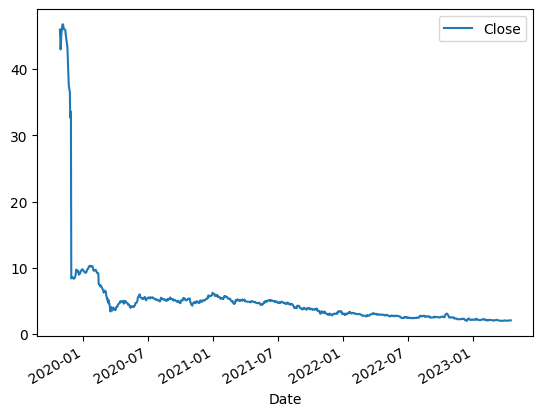

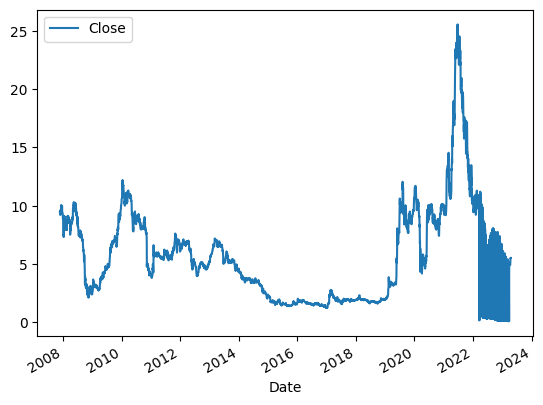

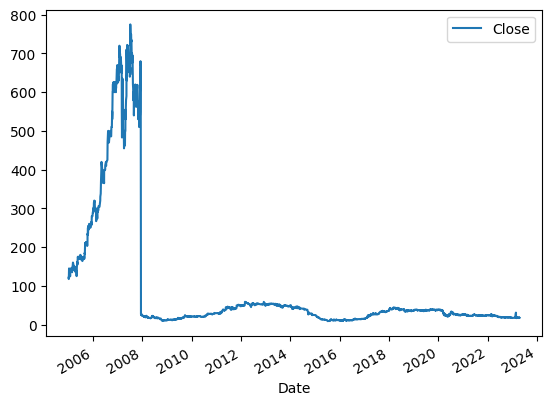

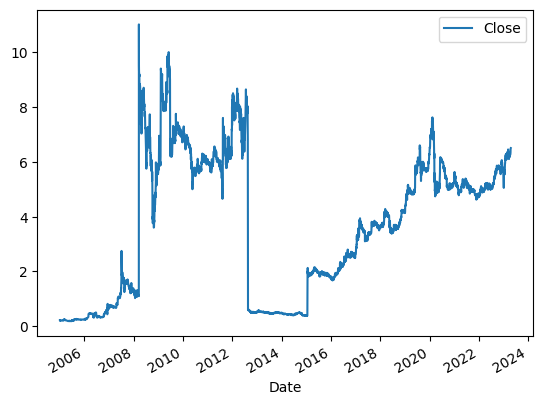

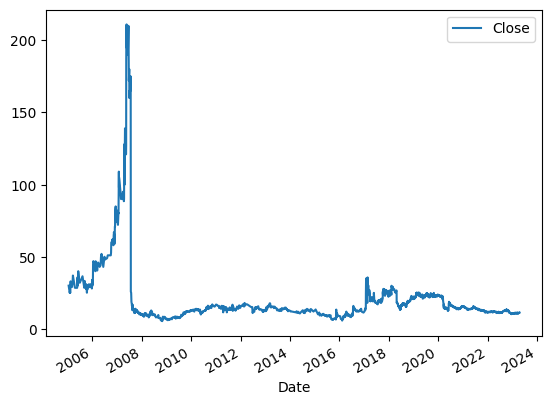

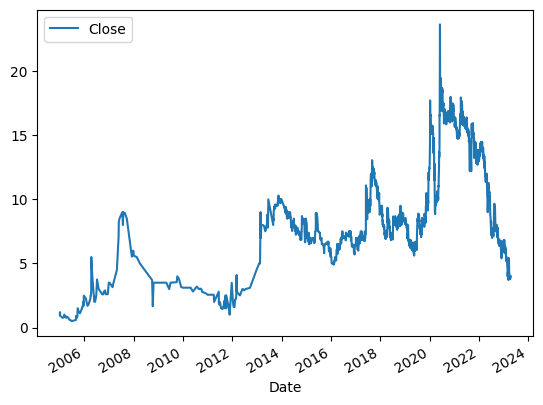

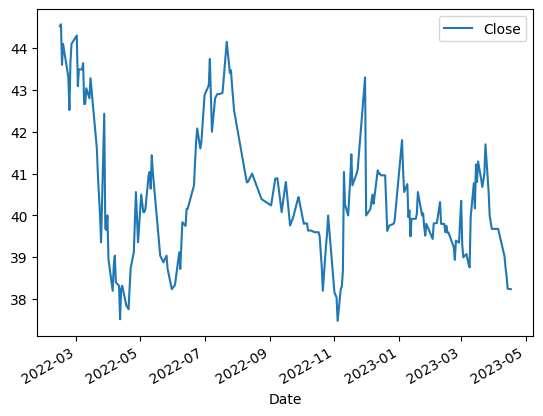

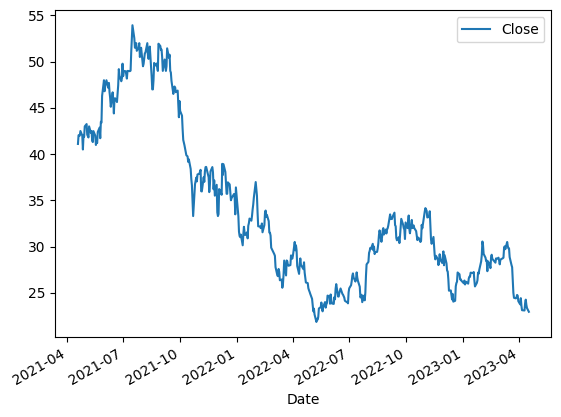

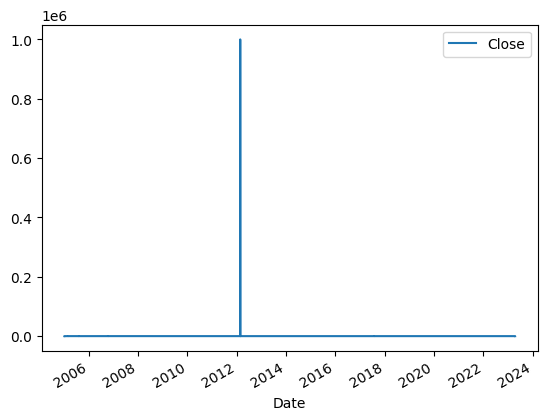

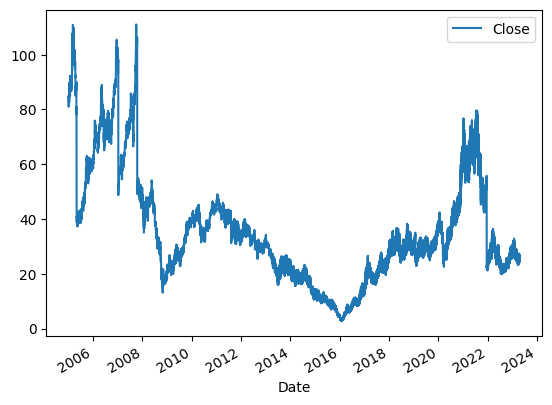

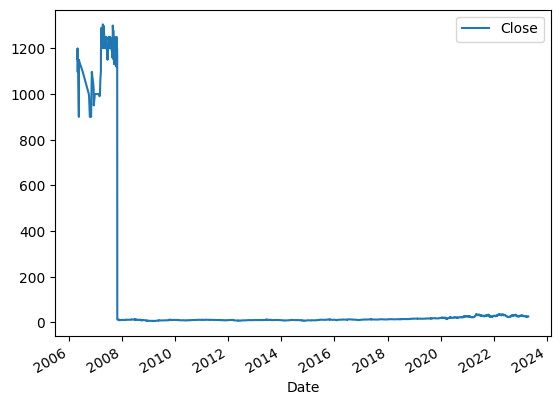

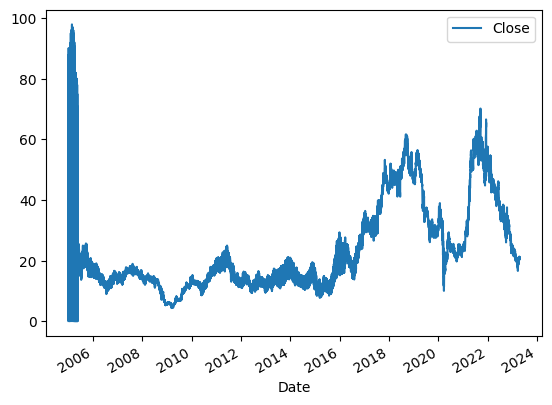

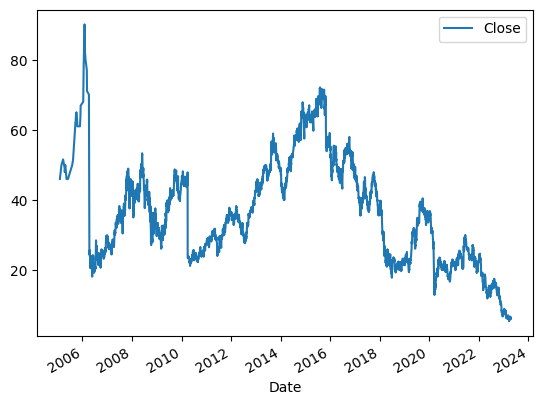

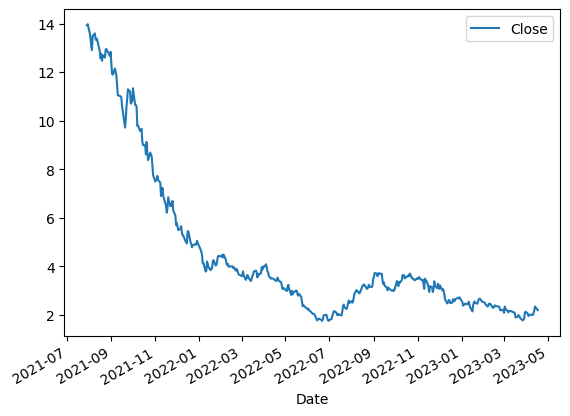

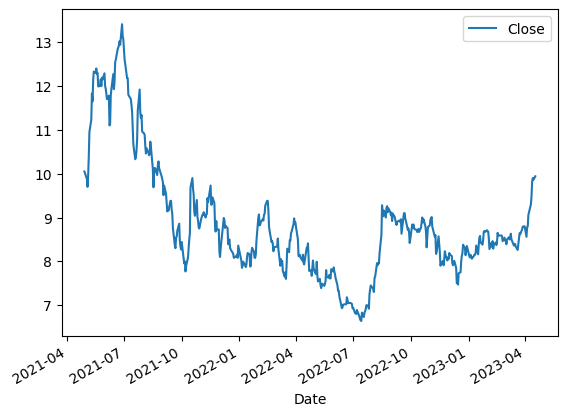

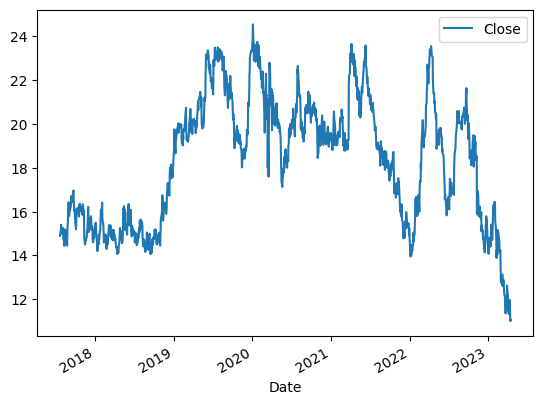

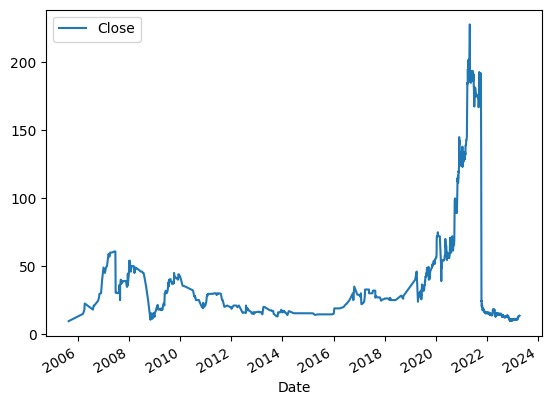

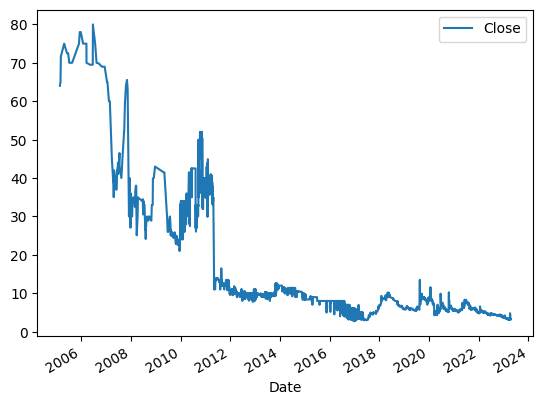

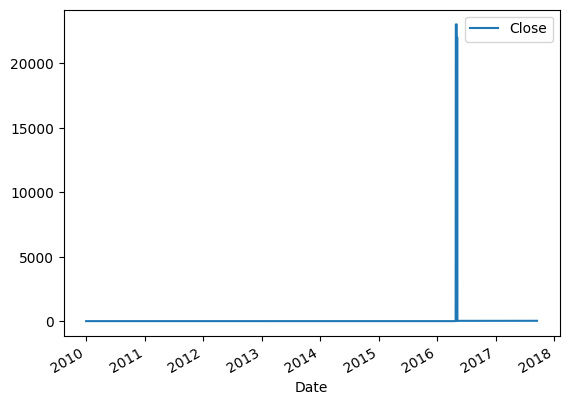

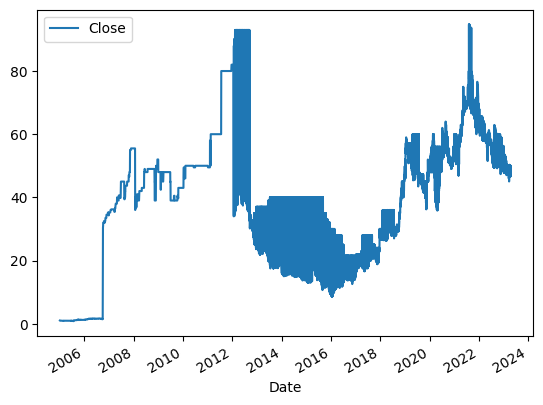

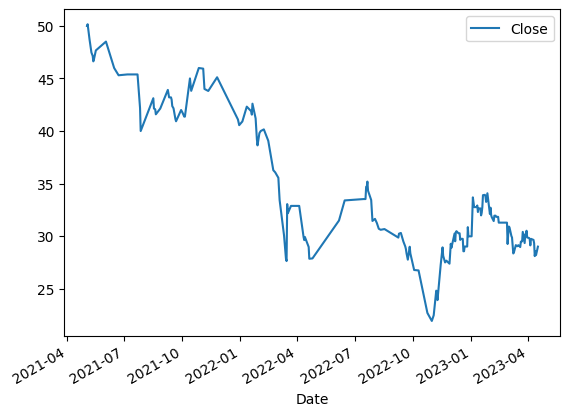

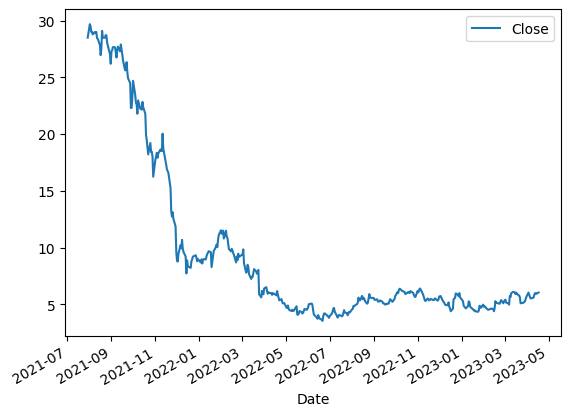

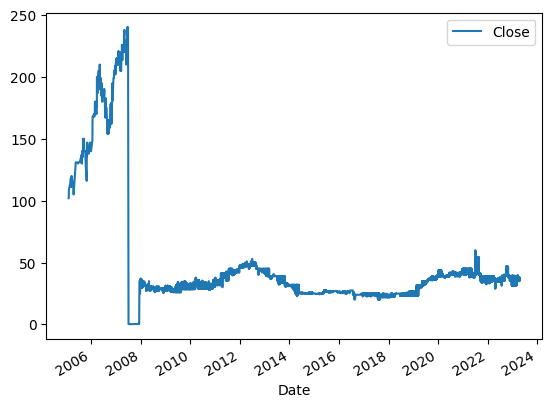

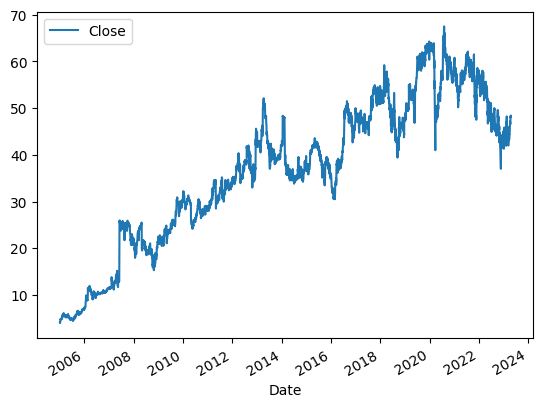

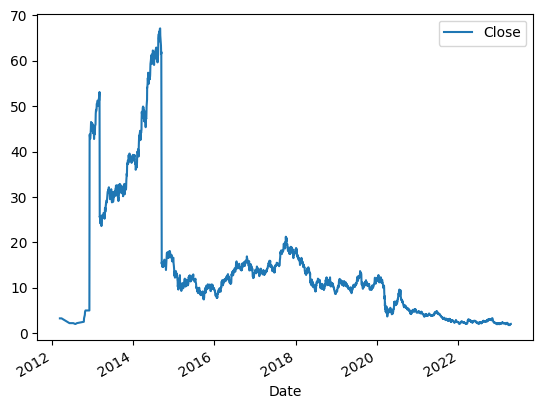

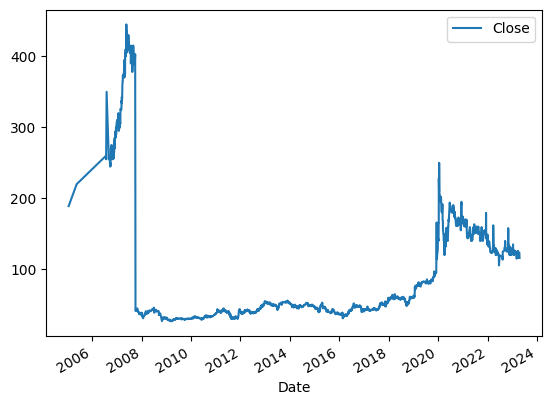

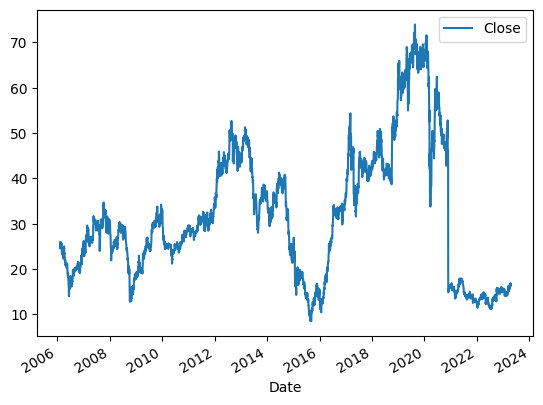

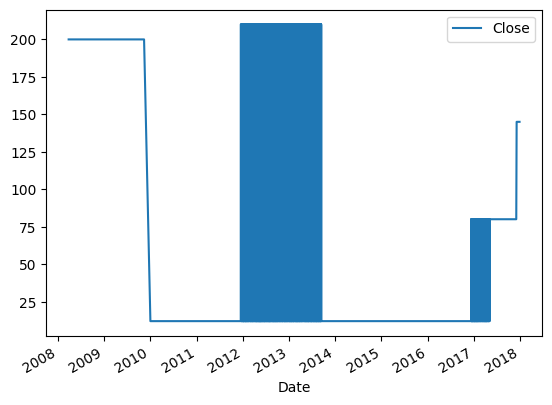

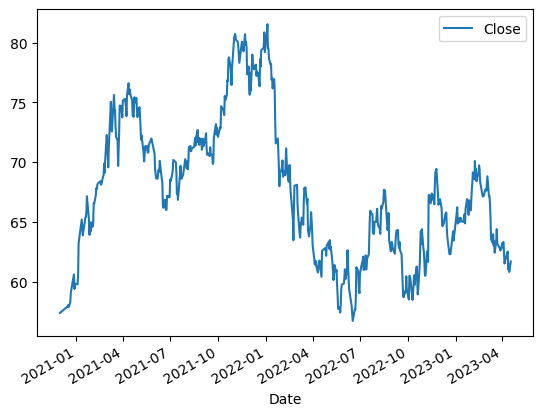

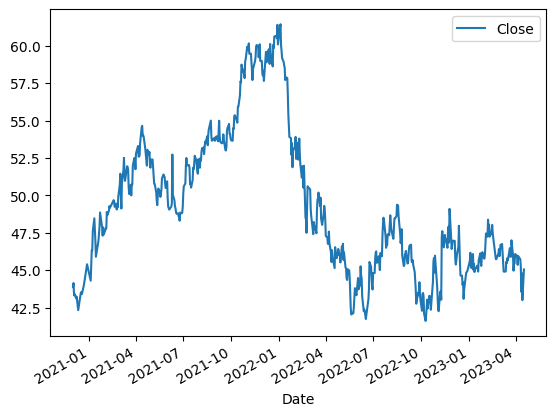

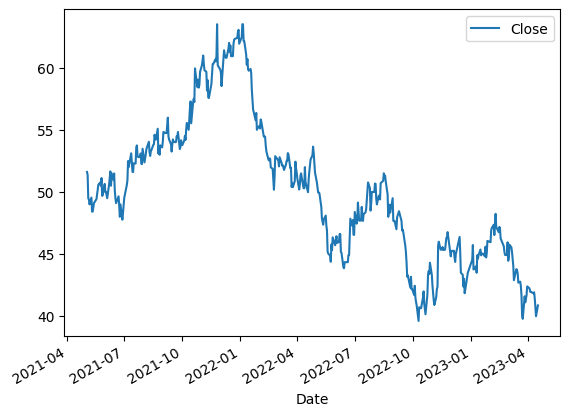

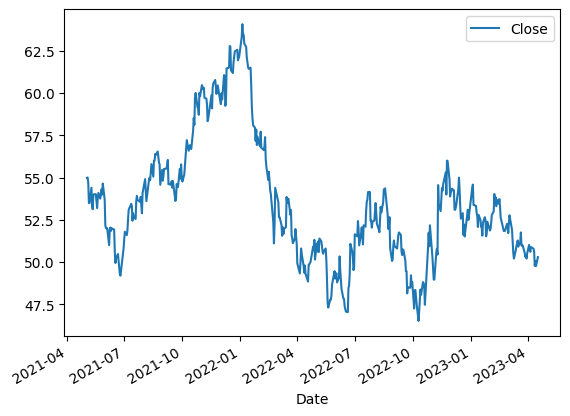

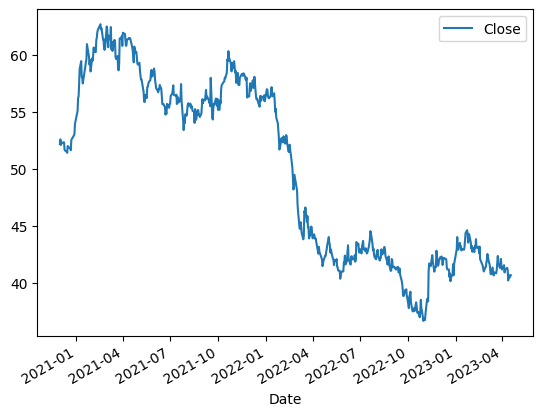

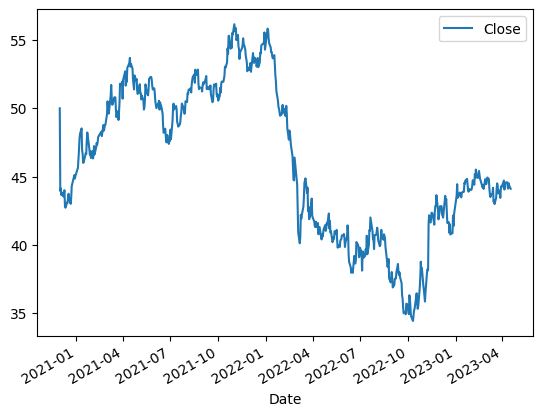

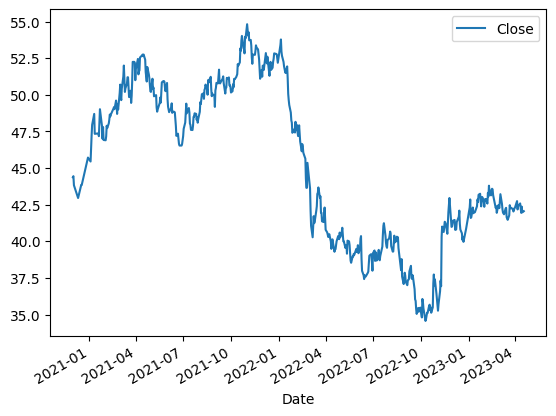

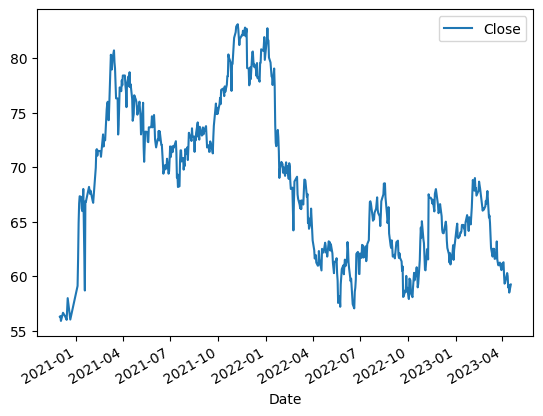

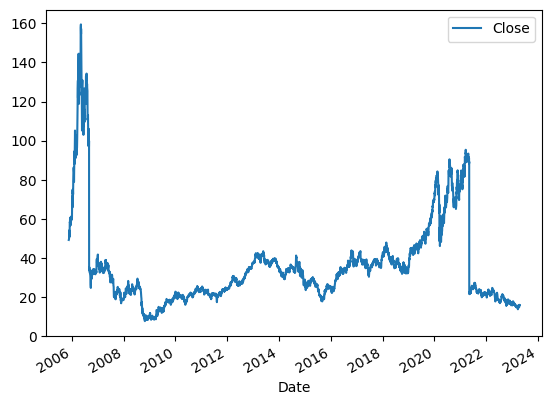

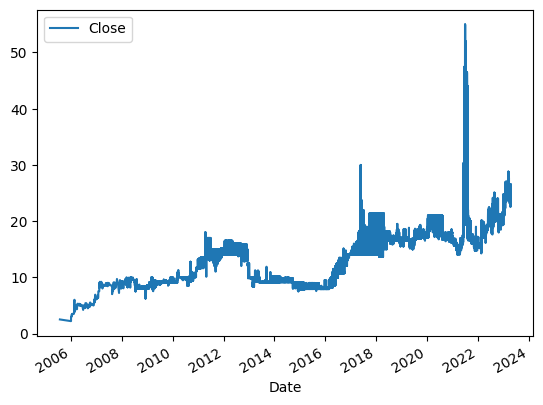

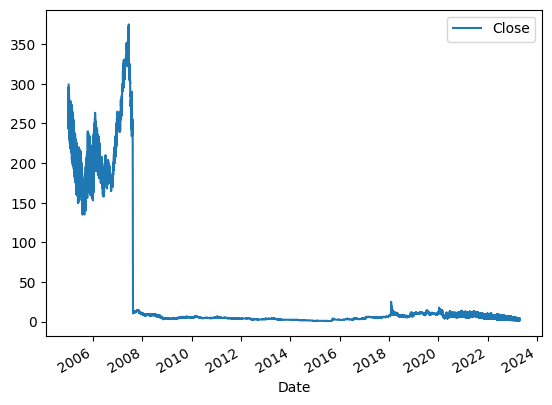

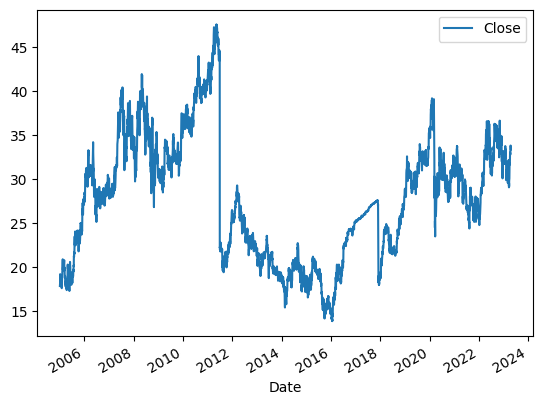

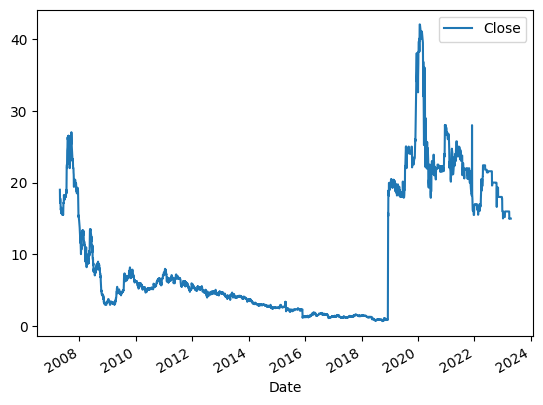

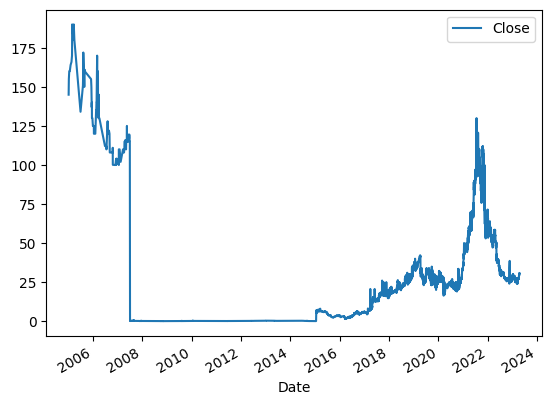

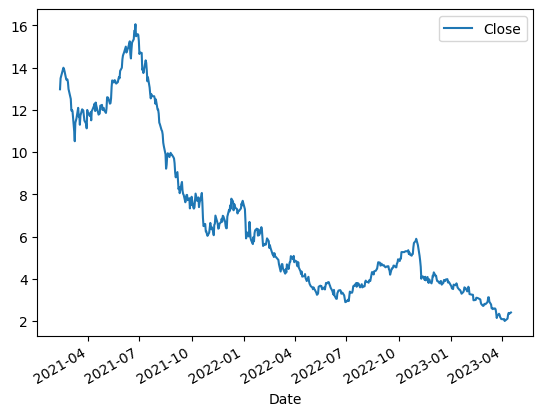

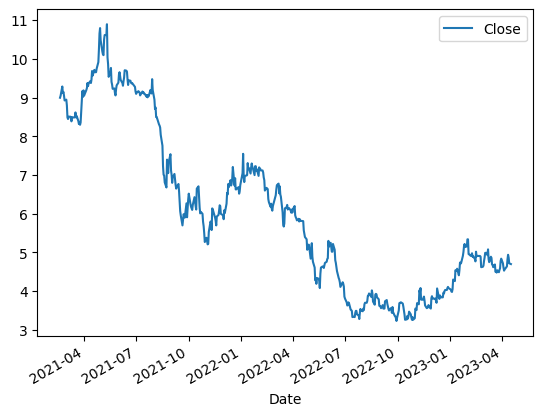

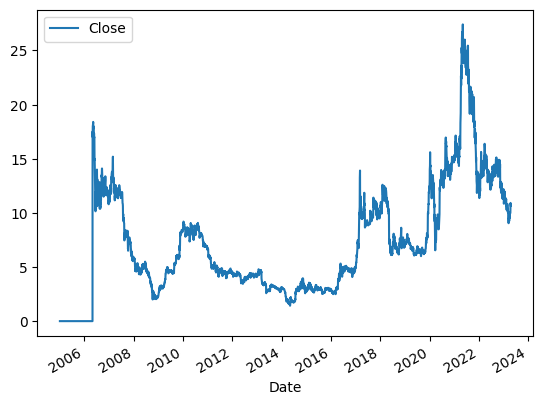

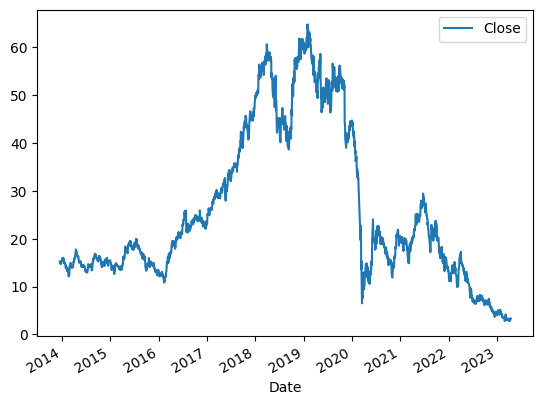

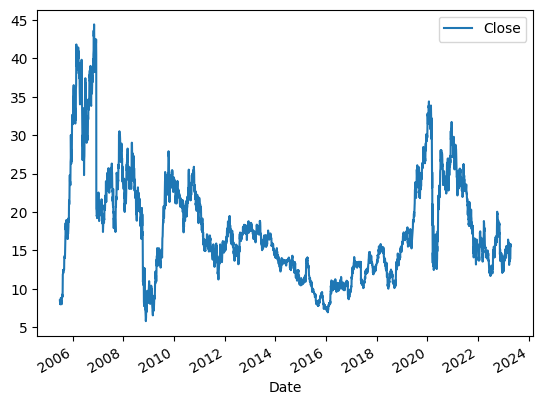

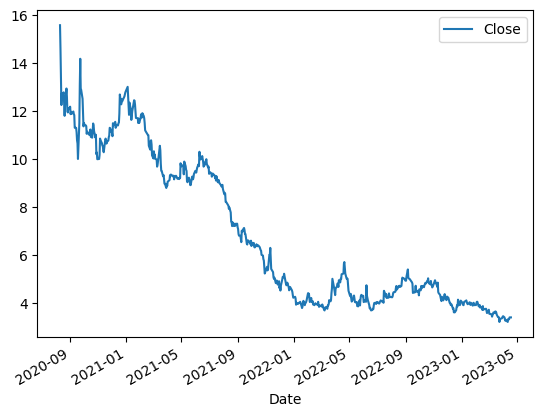

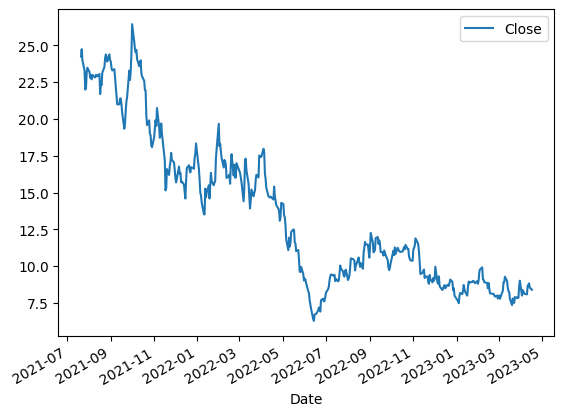

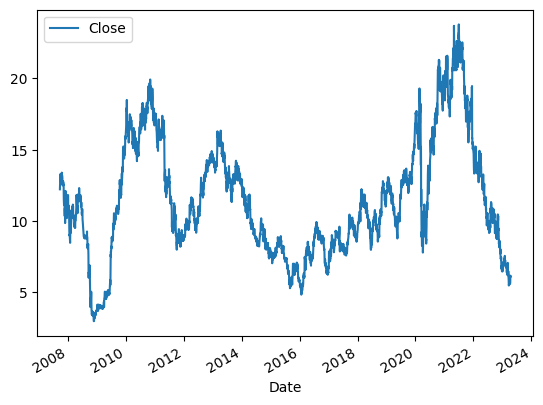

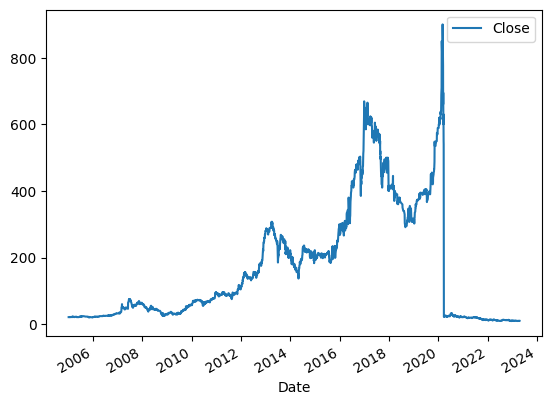

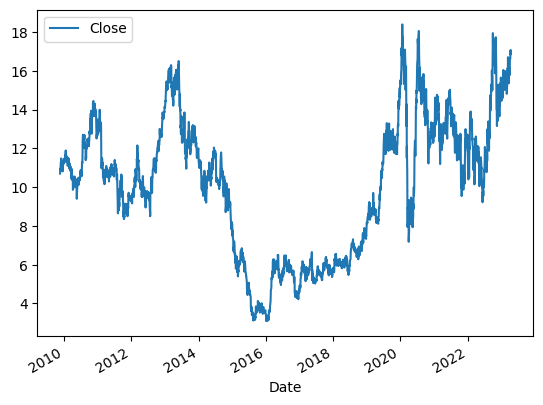

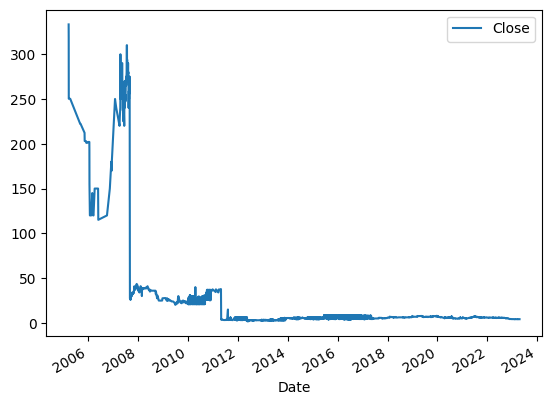

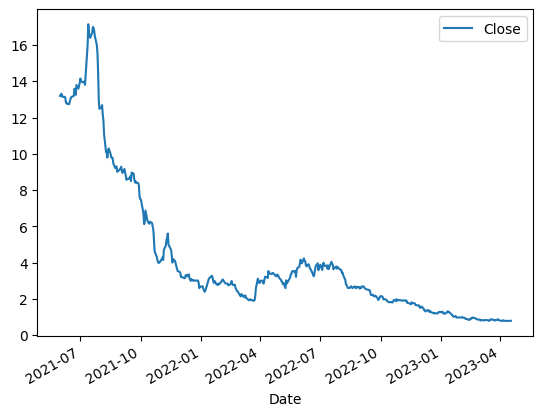

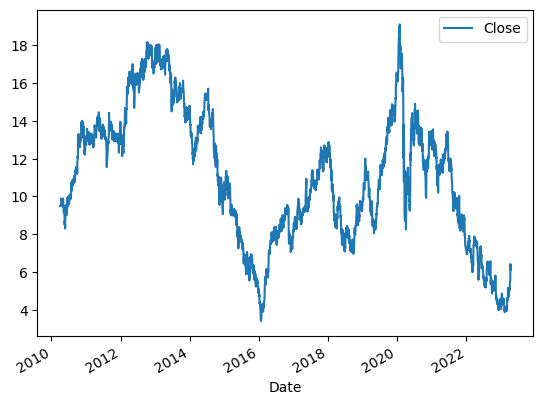

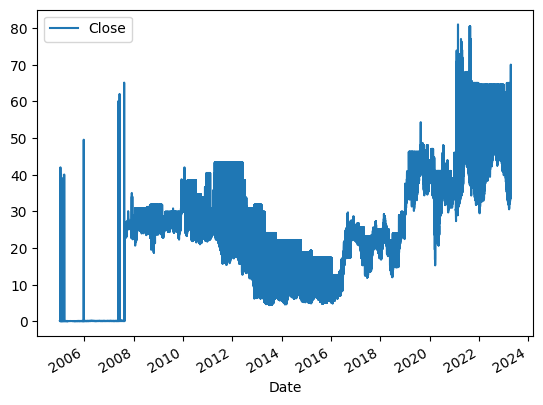

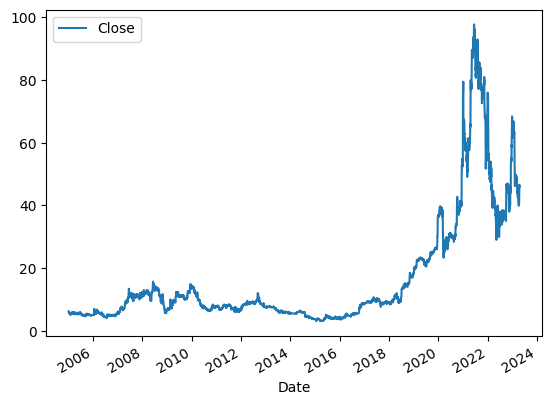

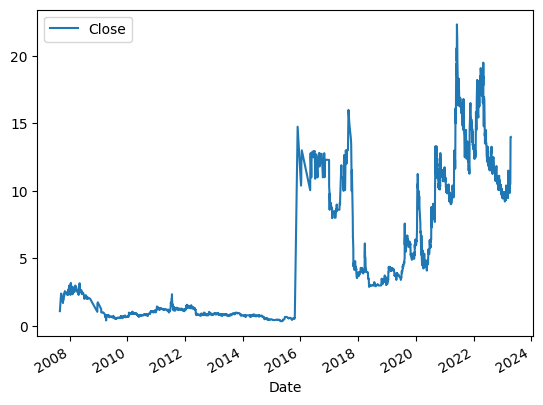

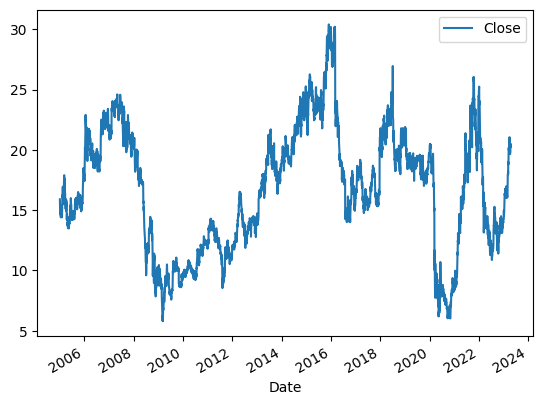

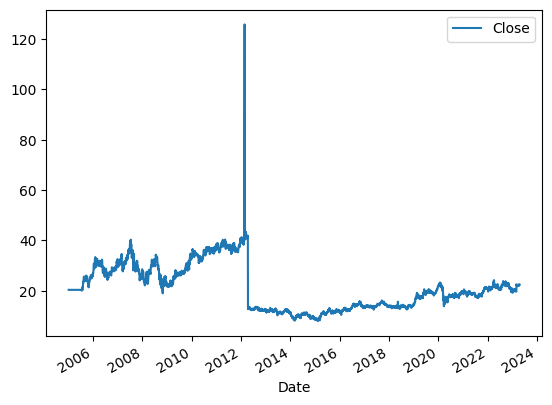

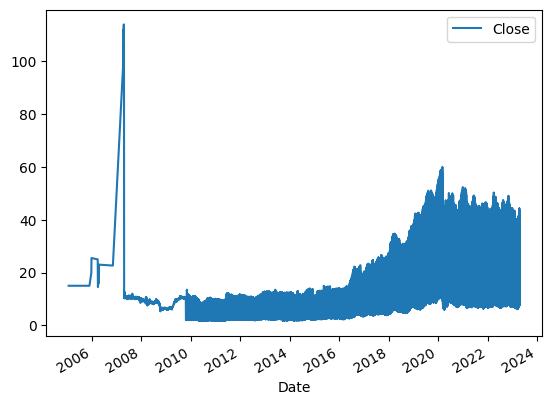

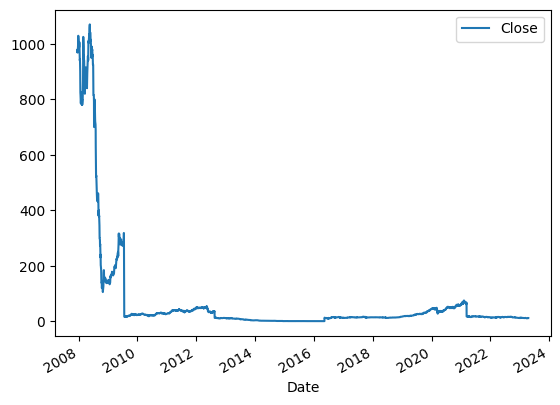

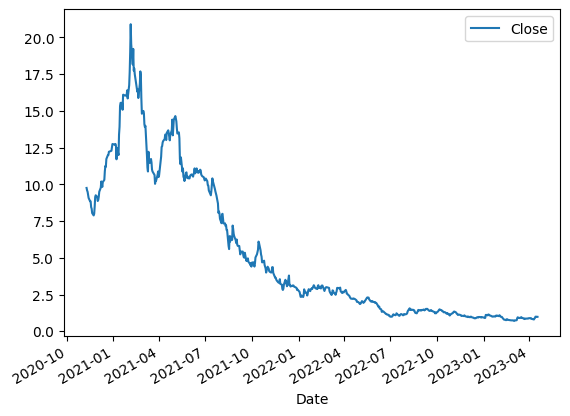

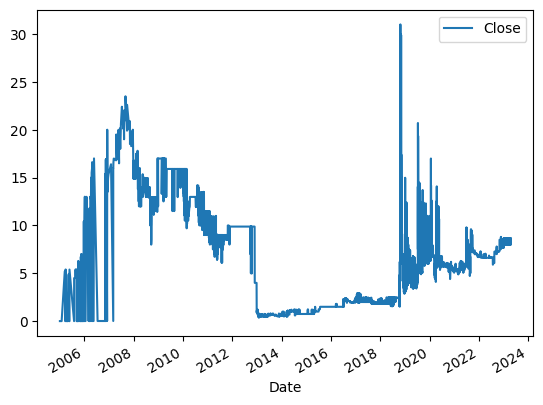

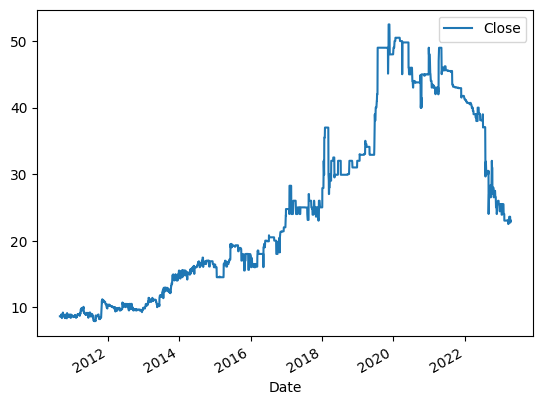

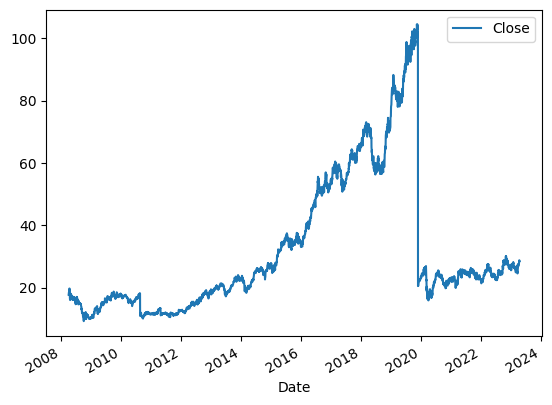

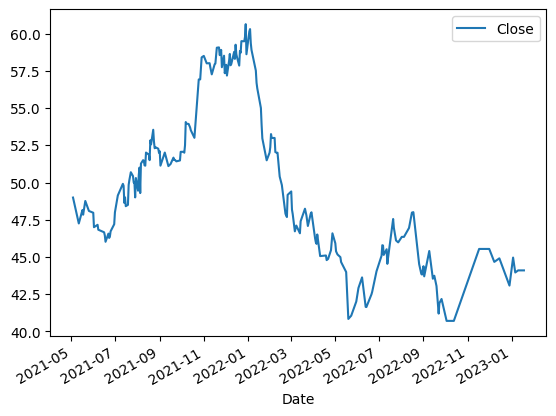

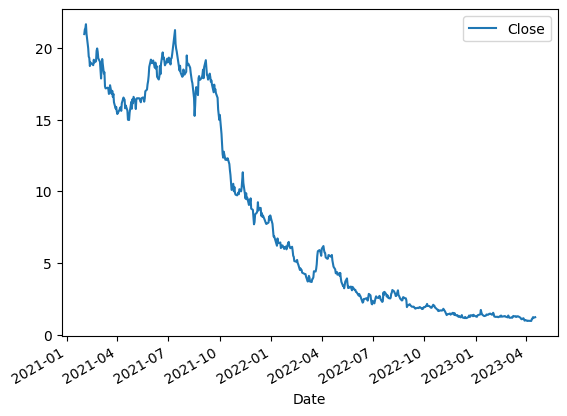

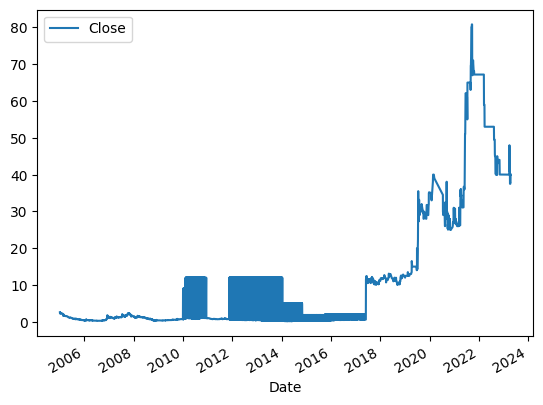

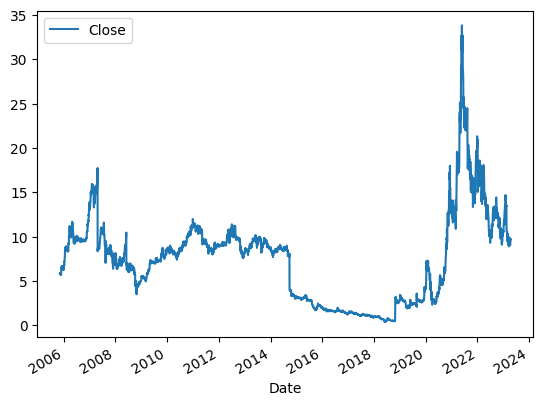

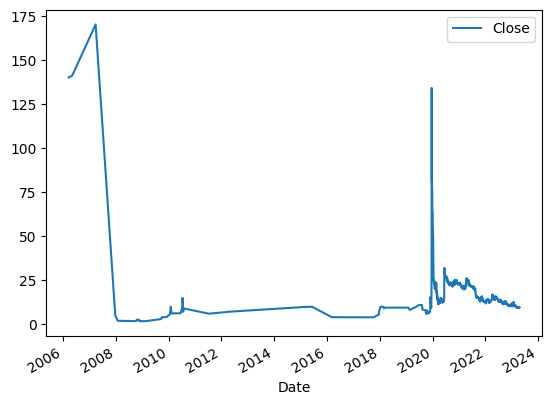

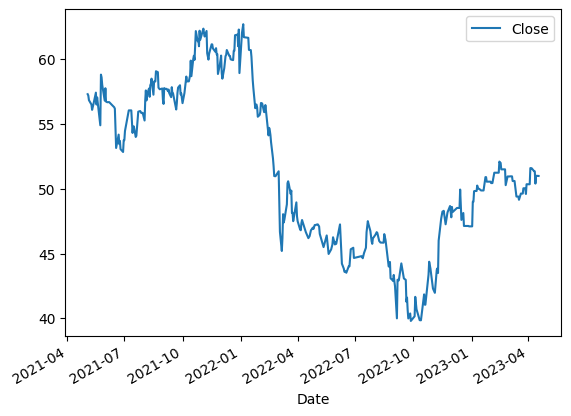

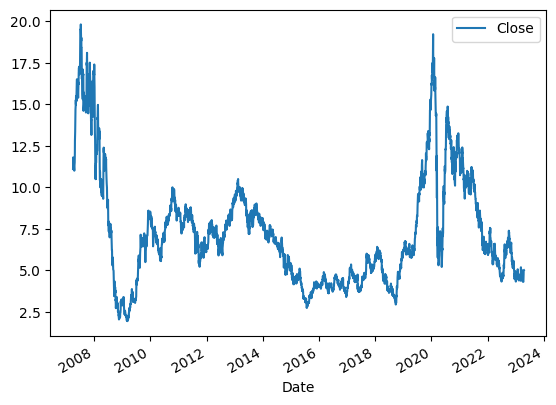

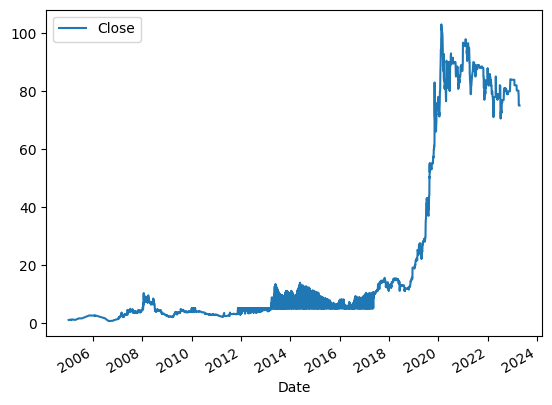

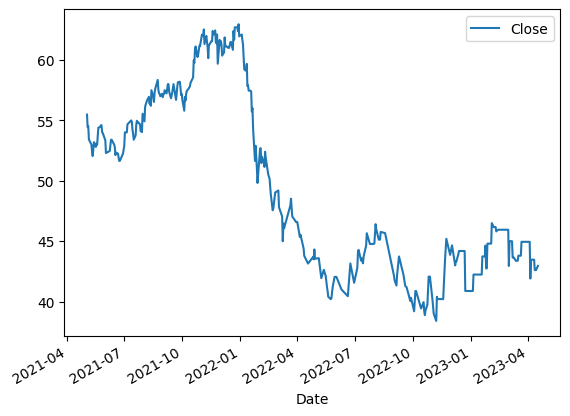

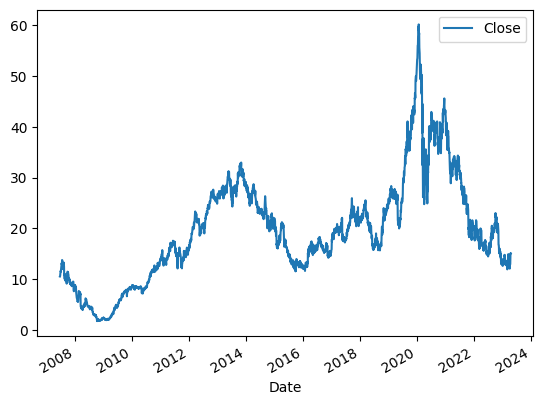

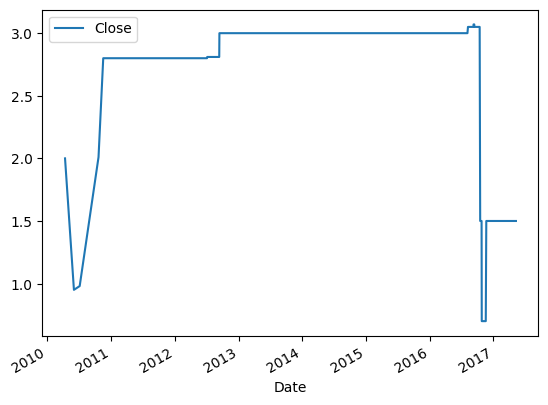

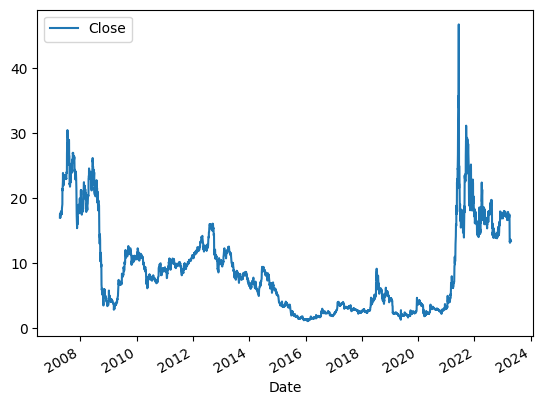

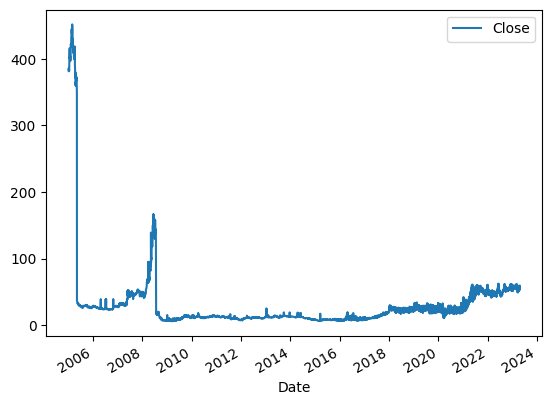

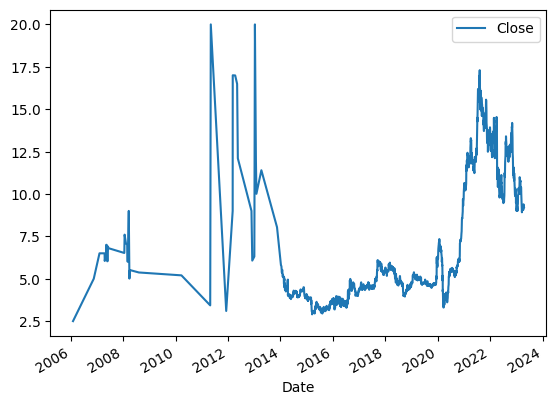

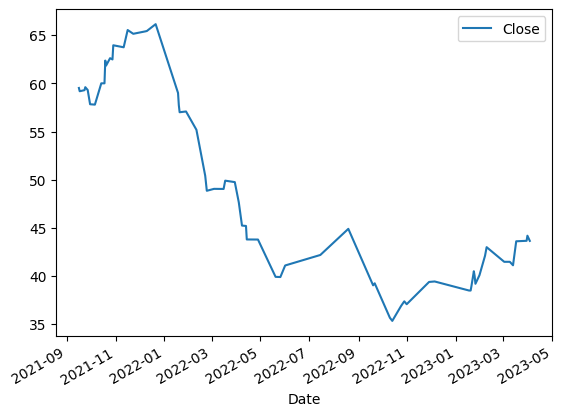

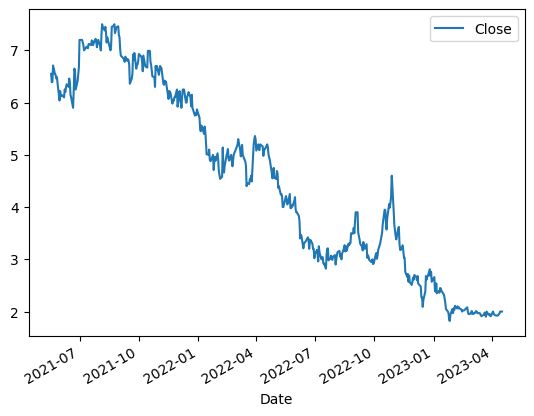

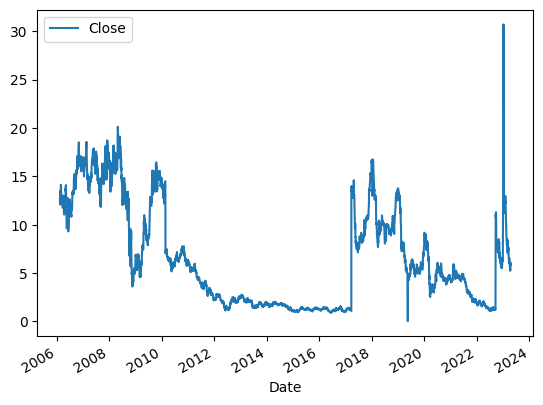

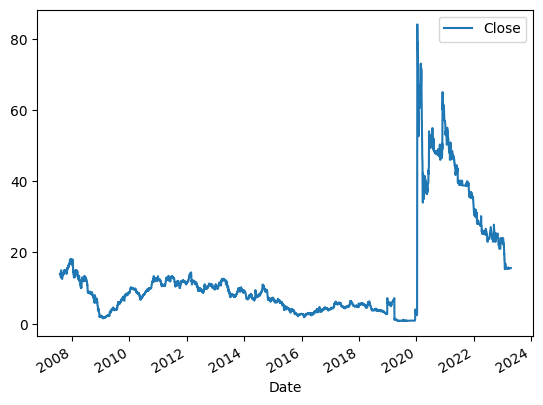

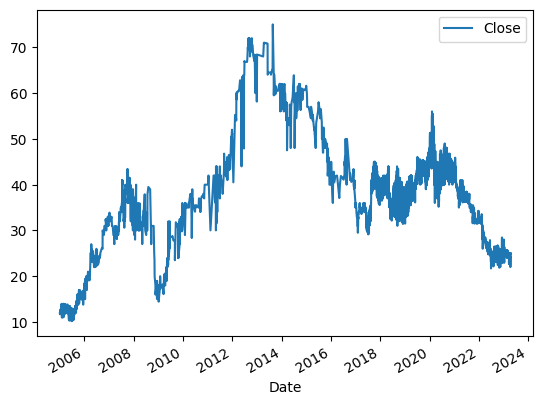

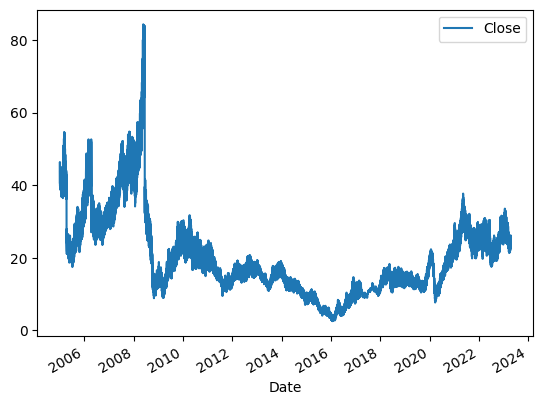

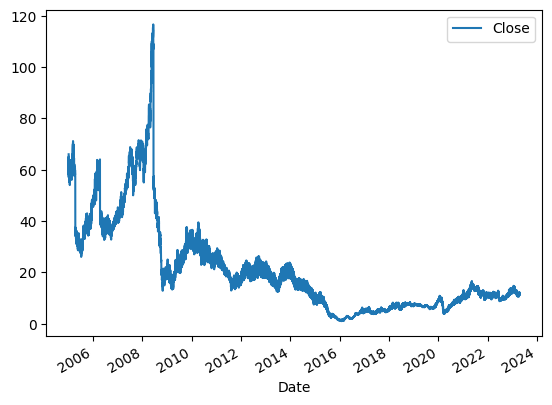

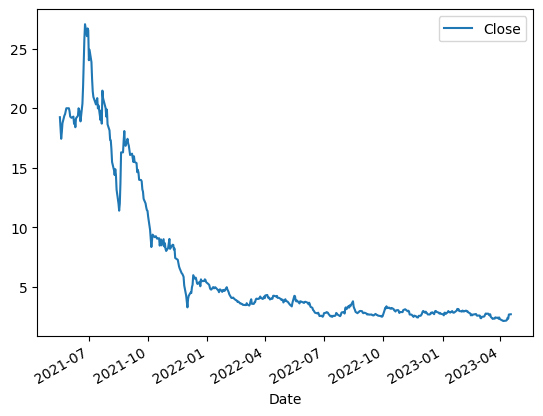

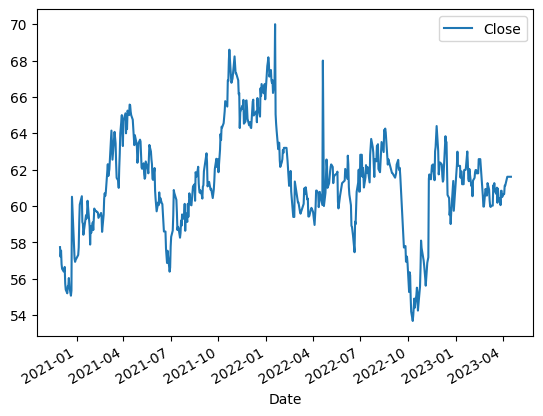

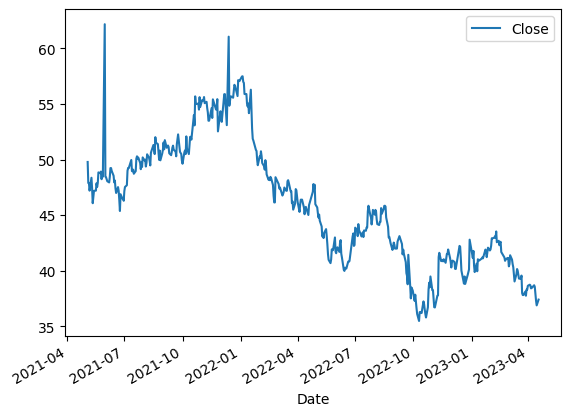

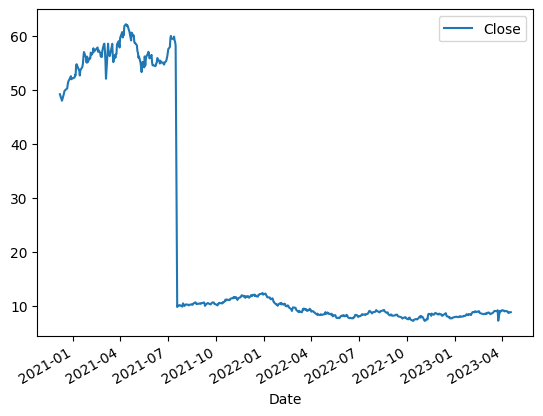

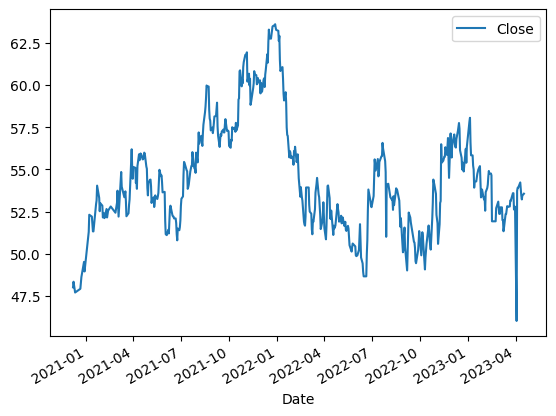

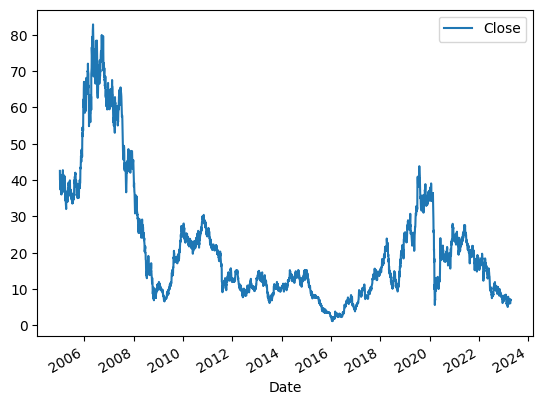

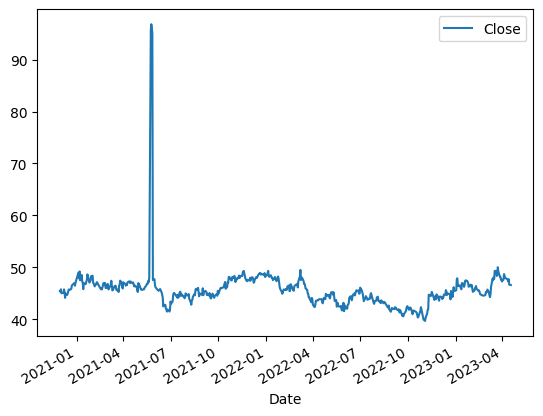

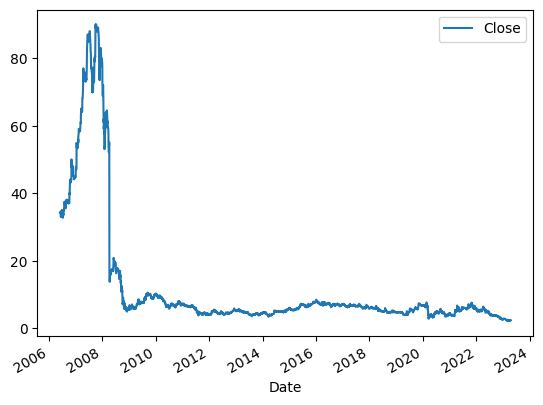

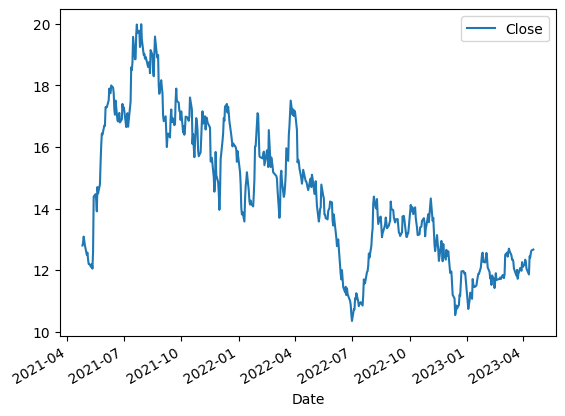

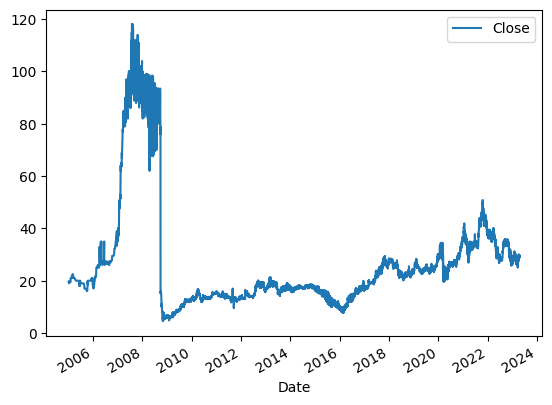

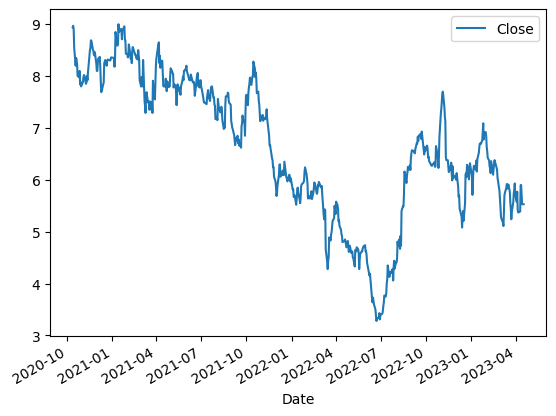

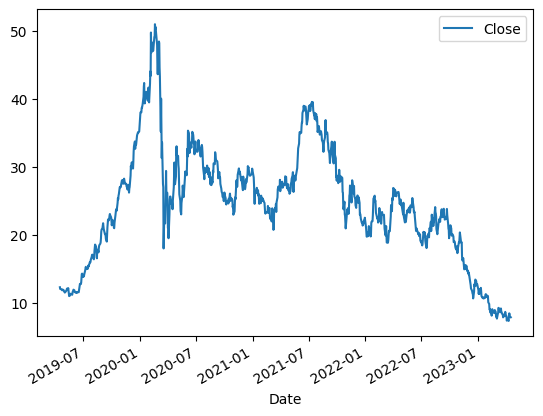

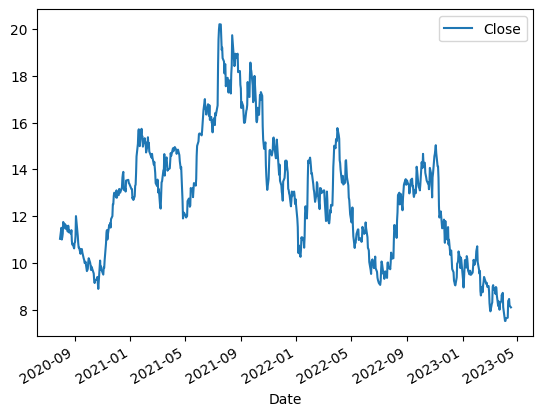

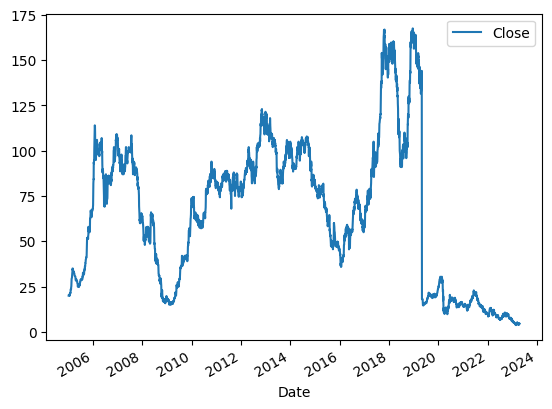

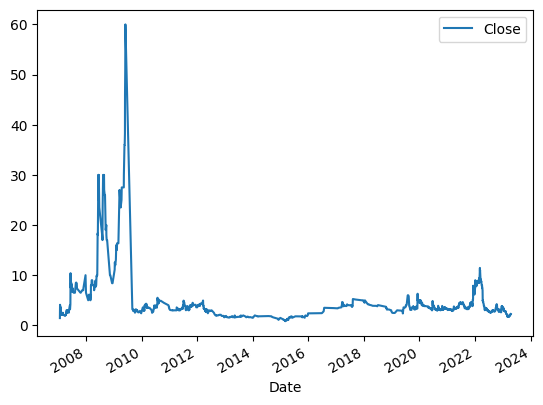

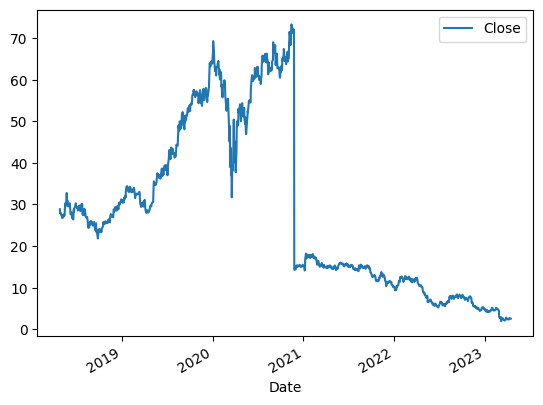

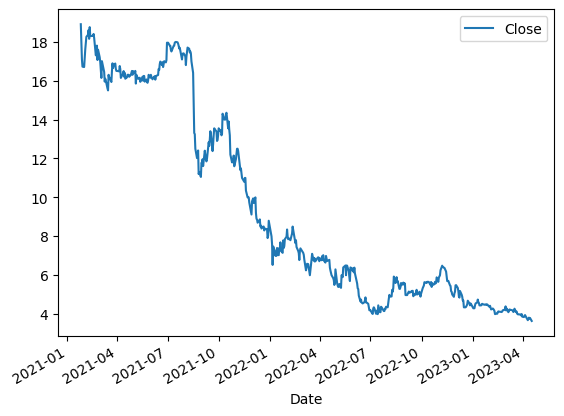

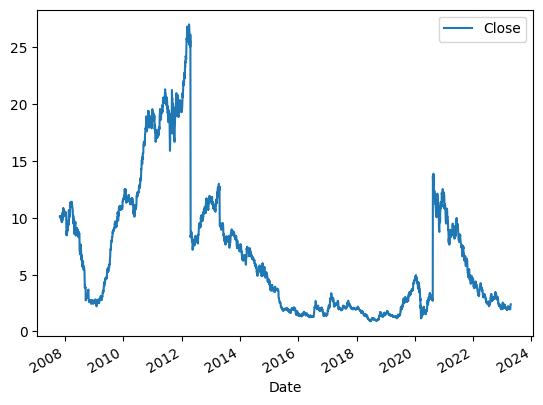

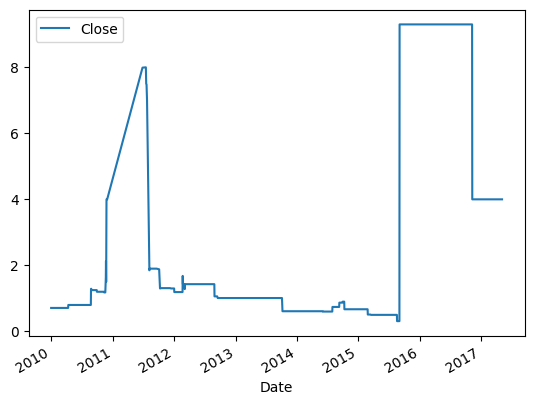

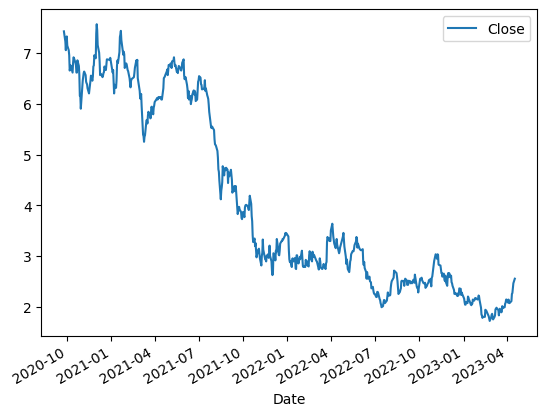

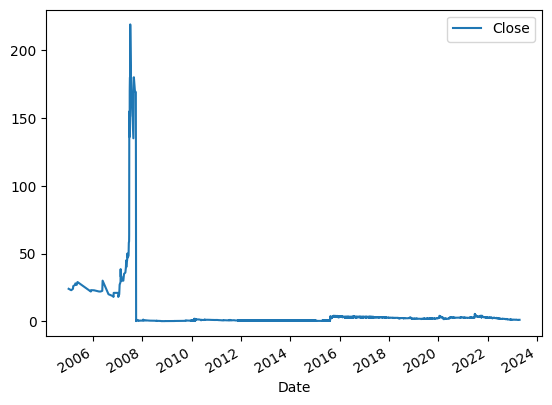

Error in callback <function flush_figures at 0x000001C4045015A0> (for post_execute):


KeyboardInterrupt: 

In [85]:
mask = cotahist['company'] == company
corp.plot(x='Date', y='Close')

## alpha vantage

In [68]:
import pandas as pd
import itertools
from alpha_vantage.timeseries import TimeSeries
import credentials.keys

# Create an API key rotator
alpha_vantage = credentials.keys.alpha_vantage
api_key_rotator = itertools.cycle(alpha_vantage)

def get_api_key():
    return next(api_key_rotator)

# Get the first API key to initialize the TimeSeries object
api_key = get_api_key()

# Create a TimeSeries object with the current API key
ts = TimeSeries(key=api_key, output_format='pandas')

symbols = ['AAPL', 'GOOGL', 'PETR4.SAO']
data_dict = {}

for symbol in symbols:
    while True:
        try:
            data, metadata = ts.get_daily_adjusted(symbol=symbol, outputsize='full')
            data_dict[symbol] = data
            print(f"{symbol}: {api_key} success")
            break
        except Exception as e:
            # Update the API key and TimeSeries object
            print(f"{symbol}: {api_key} error {e}")
            api_key = get_api_key()
            ts = TimeSeries(key=api_key, output_format='pandas')

# Print the historical quotes for each symbol
for symbol, data in data_dict.items():
    print(f"\n{symbol} Data:\n{data}")


AAPL: 0D6Q4J59U8XVBS7F success
GOOGL: 0D6Q4J59U8XVBS7F success
PETR4.SAO: 0D6Q4J59U8XVBS7F success

AAPL Data:
            1. open  2. high  3. low  4. close  5. adjusted close   6. volume  \
date                                                                            
2023-04-14   164.59   166.32  163.82    165.21         165.210000  49386480.0   
2023-04-13   161.63   165.80  161.42    165.56         165.560000  68445649.0   
2023-04-12   161.22   162.06  159.78    160.10         160.100000  50133062.0   
2023-04-11   162.35   162.36  160.51    160.80         160.800000  47644217.0   
2023-04-10   161.42   162.03  160.08    162.03         162.030000  47716882.0   
...             ...      ...     ...       ...                ...         ...   
1999-11-05    84.62    88.37   84.00     88.31           0.671012   3721500.0   
1999-11-04    82.06    85.37   80.62     83.62           0.635376   3384700.0   
1999-11-03    81.62    83.25   81.00     81.50           0.619267   2932700.0  

## PDF Download

In [ ]:
import assets.helper as b3
import requests
import json
import base64
from google.cloud import storage
from io import BytesIO

# Set the required properties
codigoInstituicao = 2
numeroProtocolo = 1043145
token = '6LdVyiwaAAAAABobBnLknCD5VGGkmH9snlJBxCyr'
versaoCaptcha = 'V3'


# Send the request
base_url = 'https://www.rad.cvm.gov.br/ENET/'
url = base_url + "frmExibirArquivoIPEExterno.aspx/ExibirPDF"
headers = {"Content-Type": "application/json; charset=utf-8"}

for numeroProtocolo in range (1043146, 1043146+2):
    # # Define the JSON payload
    # data = {
    #     "codigoInstituicao": codigoInstituicao,
    #     "numeroProtocolo": numeroProtocolo,
    #     "token": token,
    #     "versaoCaptcha": versaoCaptcha, 
    # }
    # response = requests.post(url, headers=headers, data=json.dumps(data))
    # # Get the base64-encoded PDF data from the response
    # pdf_data = response.json()['d']

    # # Decode base64-encoded PDF data
    # pdf_bytes = base64.b64decode(pdf_data)

    # # Save PDF data to file
    # with open(f"{numeroProtocolo}.pdf", "wb") as f:
    #     f.write(pdf_bytes)

    
    url = f"https://www.rad.cvm.gov.br/ENET/frmDownloadDocumento.aspx?Tela=ext&numSequencia=567876&numVersao=1&numProtocolo={numeroProtocolo}&descTipo=IPE&CodigoInstituicao=1"
    response = requests.get(url)

    # Save PDF file to Google Cloud Service
    # GCS configuration
    destination_blob_name = f'{numeroProtocolo}.pdf'

    # Initialize GCS client
    client = storage.Client.from_service_account_json(b3.json_key_file)
    bucket = client.get_bucket(b3.bucket_name)

    # Upload the PDF file to GCS
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_string(response.content, content_type='application/pdf')
    # blob.upload_from_string(pdf_bytes, content_type='application/pdf')


    print(numeroProtocolo)



1043146
1043147


## BS4 NSD Links

In [ ]:
import requests
from bs4 import BeautifulSoup

empty = 0
nsd_file = 'datasets/nsd_links.zip'
cols_nsd = ['company', 'dri', 'dri2', 'dre', 'data', 'versao', 'auditor', 'auditor_rt', 'cancelamento', 'protocolo', 'envio', 'url', 'nsd']
try:
    nsd = pd.read_pickle(nsd_file)
except Exception as e:
    print(e)
    nsd = pd.DataFrame(columns=cols_nsd)

try:
    start = int(max(nsd['nsd'])) + 1
except:
    start = 1

for n in range(start, 10000):
    try:
        nsd_url = f'https://www.rad.cvm.gov.br/ENET/frmGerenciaPaginaFRE.aspx?NumeroSequencialDocumento={n}&CodigoTipoInstituicao=1'

        # Getting the HTML content from the URL
        response = requests.get(nsd_url)
        html_content = response.text

        # Parsing the HTML content with BeautifulSoup
        soup = BeautifulSoup(html_content, 'html.parser')

        # Extracting company
        nomeCompanhia_tag = soup.find('span', {'id': 'lblNomeCompanhia'})
        company = nomeCompanhia_tag.text.strip()

        # Extracting dri and dri2
        nomeDRI_tag = soup.find('span', {'id': 'lblNomeDRI'})
        dri = nomeDRI_tag.text.strip().split(' - ')[0]
        dri2 = nomeDRI_tag.text.strip().split(' - ')[-1].replace('(', '').replace(')', '')

        # Extracting 'FCA', data and versao
        descricaoCategoria_tag = soup.find('span', {'id': 'lblDescricaoCategoria'})
        descricaoCategoria = descricaoCategoria_tag.text.strip()
        versao = descricaoCategoria.split(' - ')[-1]
        data = descricaoCategoria.split(' - ')[1]
        dre = descricaoCategoria.split(' - ')[0]

        # Extracting auditor
        lblAuditor_tag = soup.find('span', {'id': 'lblAuditor'})
        auditor = lblAuditor_tag.text.strip().split(' - ')[0]

        # Extracting auditor_rt
        lblResponsavelTecnico_tag = soup.find('span', {'id': 'lblResponsavelTecnico'})
        auditor_rt = lblResponsavelTecnico_tag.text.strip()

        # Extracting protocolo
        lblProtocolo_tag = soup.find('span', {'id': 'lblProtocolo'})
        protocolo = lblProtocolo_tag.text.strip()

        # Extracting '2010' and envio
        lblDataDocumento_tag = soup.find('span', {'id': 'lblDataDocumento'})
        lblDataDocumento = lblDataDocumento_tag.text.strip()

        lblDataEnvio_tag = soup.find('span', {'id': 'lblDataEnvio'})
        envio = lblDataEnvio_tag.text.strip()

        # cancelamento
        cancelamento_tag = soup.find('span', {'id': 'lblMotivoCancelamentoReapresentacao'})
        cancelamento = cancelamento_tag.text.strip()

        # url
        url = nsd_url

        # company
        company_line = [company, dri, dri2, dre, data, versao, auditor, auditor_rt, cancelamento, protocolo, envio, url, n]
        df = pd.DataFrame([company_line], columns=cols_nsd)
        nsd = pd.concat([nsd, df])
        print(n, company_line)
        empty = 0

    except Exception as e:
        empty += 1
        print(empty, 'empty line', e)

        if empty == 2000:
            print('too much empty lines, aborting...')
            break

    if n % 2 == 0:
        nsd.to_pickle(nsd_file)
        print('partial save')

nsd.to_pickle(nsd_file)
print('final save')


45 ['MARFRIG GLOBAL FOODS S.A.', 'Ricardo Florence dos Santos', 'FCA V2', 'Formulário Cadastral', '2010', 'V1', 'BDO Trevisan Auditores Independentes', 'José Luiz Sanches', '', '020788FCA000020100100000045-80', '17/03/2010 17:03:28', 'https://www.rad.cvm.gov.br/ENET/frmGerenciaPaginaFRE.aspx?NumeroSequencialDocumento=45&CodigoTipoInstituicao=1', 45]
1 empty line list index out of range
partial save
2 empty line list index out of range
48 ['RENOVA ENERGIA S.A. - EM RECUPERAÇÃO JUDICIAL', 'Vasco de Freitas Barcellos Neto', 'FCA V1', 'Formulário Cadastral', '2010', 'V1', '', '', '', '021636FCA000020100100000048-86', '18/03/2010 13:21:56', 'https://www.rad.cvm.gov.br/ENET/frmGerenciaPaginaFRE.aspx?NumeroSequencialDocumento=48&CodigoTipoInstituicao=1', 48]
partial save
1 empty line list index out of range
2 empty line list index out of range
partial save
3 empty line list index out of range
4 empty line list index out of range


KeyboardInterrupt: 

In [ ]:
nsd

company  \
0                                            NaN   
0                      MARFRIG GLOBAL FOODS S.A.   
0  RENOVA ENERGIA S.A. - EM RECUPERAÇÃO JUDICIAL   

                               dri    dri2                   dre  data versao  \
0                              NaN     NaN                   NaN   NaN    NaN   
0      Ricardo Florence dos Santos  FCA V2  Formulário Cadastral  2010     V1   
0  Vasco de Freitas Barcellos Neto  FCA V1  Formulário Cadastral  2010     V1   

                                auditor         auditor_rt cancelamento  \
0                                   NaN                NaN          NaN   
0  BDO Trevisan Auditores Independentes  José Luiz Sanches                
0                                                                         

                        protocolo  ...                     3     4    5    6  \
0                             NaN  ...  Formulário Cadastral  2010   V1        
0  020788FCA000020100100000045-80  ...                   NaN   NaN  NaN  NaN   
0  021636FCA000020100100000048-86  ...                   NaN   NaN  NaN  NaN   

     7    8                               9                   10  \
0            021636FCA000020100100000048-86  18/03/2010 13:21:56   
0  NaN  NaN                             NaN                  NaN   
0  NaN  NaN                             NaN                  NaN   

                                                  11   12  
0  https://www.rad.cvm.gov.br/ENET/frmGerenciaPag...   48  
0                                                NaN  NaN  
0                                                NaN  NaN  

[3 rows x 26 columns]

In [ ]:
# nsd = pd.concat([nsd, df])


In [ ]:
nsd = pd.DataFrame(columns=cols_nsd)

In [ ]:
df

company  \
0  RENOVA ENERGIA S.A. - EM RECUPERAÇÃO JUDICIAL   

                               dri    dri2                   dre  data versao  \
0  Vasco de Freitas Barcellos Neto  FCA V1  Formulário Cadastral  2010     V1   

  auditor auditor_rt cancelamento                       protocolo  \
0                                  021636FCA000020100100000048-86   

                 envio                                                url  nsd  
0  18/03/2010 13:21:56  https://www.rad.cvm.gov.br/ENET/frmGerenciaPag...   48

In [ ]:
nsd = pd.concat([nsd, df.T])
nsd

company  dri dri2  dre data versao auditor auditor_rt cancelamento  \
0     NaN  NaN  NaN  NaN  NaN    NaN     NaN        NaN          NaN   

  protocolo  ...                     3     4   5 6 7 8  \
0       NaN  ...  Formulário Cadastral  2010  V1         

                                9                   10  \
0  021636FCA000020100100000048-86  18/03/2010 13:21:56   

                                                  11  12  
0  https://www.rad.cvm.gov.br/ENET/frmGerenciaPag...  48  

[1 rows x 26 columns]

In [ ]:
cotahist = pd.read_pickle('datasets/cotahist.zip')


In [ ]:
cotahist.columns

Index(['company', 'dri', 'dri2', 'dre', 'data', 'versao', 'auditor',
       'auditor_rt', 'cancelamento', 'protocolo', 'envio', 'url', 'nsd'],
      dtype='object')